> I dont think it make sense to use the samples that don't have a `HMRRHGCTRLSURGMINS` because if you use the `ICDPROCEDUREMINS` then you have to pick between the different times that the sometime multiple procedures were started, all of which are part of thoracotomy? I guess one route to go would be to just take the first time for related procedures and just running with that for now. This seems like to me that we are going to be doubling the number of samples but at the cost of muckying the water. This would mean more than 50% of the samples would not be labeled as a RT with 100% certainty, although highly likely that these ICD codes performed in the context of emergency within first 20 minutes following arrival would be anything else. I do wonder if it's better to run a cleaner study to stick the concretely known data since there is still considerable data, although the jump in data bby using it all is technically to the next order of magnitude. It is also important to consider that I need to ensure that other damage control procedures (i.e. thoracotomy) are also removed with certainty. So truthfully, if there are people in the ICD group that have a damage control surgery listed that is not thoracotomy but had the other ICD procedures, it needs to be ruled out from the data being used. 

> After consulting the data dictionary and seeing how things are labeled, it is unclear what to make of scenarios where there is a missing damage control surgery type despite having related ICD codes used and how to handle the scenario where there is not one listed/ `None` is listed yet have related ICD codes, varying start times of the procedures etc etc. 

> Another caveat is that damage control surgery type is only a field included when there is PRBCs administered in the first 4 hours PTA so it is possible that there are scenarios (clinically uncommon?) in which a RT could occur without administration of blood? Could look for this in the data base.

> Moral of the story, I think this study has an unnecessary amount of complexity, ambiguity and decline in certainty by trying to include these edge cases. I think going forward it is best to stick with what we know concretely to avoid associated issues.

# `2017 - 2022` Analysis

# Load in libraries

In [3]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from itertools import combinations
from collections import defaultdict

# Create dictionaries, file paths and desired columns of data fields

In [4]:
data_fp = '/Users/JakeCanfield/Documents/Trauma_Surgery_Research/Data/Raw_data/PUF AY %i/CSV/'
years = range(2017, 2023)
thoracotomy_codes = ['0WJB0ZZ', '0WJ90ZZ', '02JA0ZZ', '02JY0ZZ', '0BJL0ZZ', '0BJK0ZZ', '0BJQ0ZZ','0WJ80ZZ', '0WJC0ZZ', '0WJD0ZZ', '02VW0CZ', '02QA0ZZ', '3E080GC']
sternotomy_codes = ['0P800ZZ']

mechanism_code_dict = {1:'Cut/pierce', 2:'Drowning/submersion', 3:'Fall', 4:'Fire/flame', 5:'Hot object/substance', 6:'Firearm', 7:'Machinery', 8:'MVT Occupant', 9:'MVT Motorcyclist', 10:'MVT Pedal cyclist', 11:'MVT Pedestrian', 12:'MVT Unspecified', 13:'MVT Other', 14:'Pedal cyclist, other', 15:'Pedestrian, other', 16:'Transport, other', 17:'Natural/environmental,  Bites and stings', 18:'Natural/environmental,  Other', 19:'Overexertion', 20:'Poisoning', 21:'Struck by, against', 22:'Suffocation', 23:'Other specified and classifiable', 24:'Other specified, not elsewhere classifiable', 25:'Unspecified', 26:'Adverse effects, medical care', 27:'Adverse effects, drugs'} # As noted in PUF dictionary
trauma_type_code_dict = {1:'Blunt', 2:'Penetrating', 3:'Burn', 4:'Other/unspecified', 9:'Activity Code - Not Valid as a Primary E-Code'} # As noted in PUF Dictionary
sex_code_dict = {1:'Male', 2:'Female', 3:'Unknown'}
eddischarge_code_dict = {1: 'Floor bed (general admission, non-specialty unit bed)', 2: 'Observation unit (unit that provides < 24 hour stays)', 3: 'Telemetry/step-down unit (less acuity than ICU)', 4: 'Home with services', 5: 'Deceased/expired', 6: 'Other (jail, institutional care, mental health, etc.)', 7: 'Operating Room', 8: 'Intensive Care Unit (ICU)', 9: 'Home without services', 10: 'Left against medical advice', 11: 'Transferred to another hospital'}
hospdischarge_disposition_code_dict = {1: 'Discharged/Transferred to a short-term general hospital for inpatient care', 2: 'Discharged/Transferred to an Intermediate Care Facility (ICF)', 3: 'Discharged/Transferred to home under care of organized home health service', 4: 'Left against medical advice or discontinued care', 5: 'Deceased/Expired', 6: 'Discharged to home or self-care (routine discharge)', 7: 'Discharged/Transferred to Skilled Nursing Facility (SNF)', 8: 'Discharged/Transferred to hospice care', 10: 'Discharged/Transferred to court/law enforcement', 11: 'Discharged/Transferred to inpatient rehab or designated unit', 12: 'Discharged/Transferred to Long Term Care Hospital (LTCH)', 13: 'Discharged/Transferred to a psychiatric hospital or psychiatric distinct part unit of a hospital', 14: 'Discharged/Transferred to another type of institution not defined elsewhere'}
deathined_code_dict = {1:'Arrived with NO signs of life', 2:'Arrived with signs of life'}
prehospca_code_dict = {1:'Yes', 2:'No'}
transport_mode_code_dict = {1:'Ground Ambulance', 2:'Helicopter Ambulance', 3:'Fixed-wing Ambulance', 4:'Private/Public Vehicle/Walk-in', 5:'Police', 6:'Other'}

cols17 = pd.read_csv(data_fp%(2017)+'PUF_TRAUMA.csv', nrows=1).columns.tolist()
cols19 = pd.read_csv(data_fp%(2017)+'PUF_TRAUMA.csv', nrows=1).columns.tolist()
cols17 = [x.upper() for x in cols17]
cols19 = [x.upper() for x in cols19]

common_cols = list(set(cols17) & set(cols19))

# Data Exploration of Thoracotomy Data Population

## Combine years of data into one `DataFrame` for figure generation

### Combine both filtering methods together

In [41]:
TRAUMA_all_df_HMRRHGCTRLSURG = pd.read_csv('/Users/JakeCanfield/Documents/Trauma_Surgery_Research/data/Combined_data/TRAUMA_all_df_HMRRHGCTRLSURG.csv')
TRAUMA_all_df_ICD = pd.read_csv('/Users/JakeCanfield/Documents/Trauma_Surgery_Research/data/Combined_data/TRAUMA_all_df_ICD.csv')

display(np.shape(TRAUMA_all_df_ICD['HMRRHGCTRLSURGTYPE']))

TRAUMA_all_df_ICD = TRAUMA_all_df_ICD[TRAUMA_all_df_ICD['HMRRHGCTRLSURGTYPE'] != 3.0]

TRAUMA_all_df = pd.concat([TRAUMA_all_df_HMRRHGCTRLSURG, TRAUMA_all_df_ICD])
display(TRAUMA_all_df.head())

display(np.shape(TRAUMA_all_df_HMRRHGCTRLSURG['HMRRHGCTRLSURGTYPE']))
display(np.shape(TRAUMA_all_df_ICD['HMRRHGCTRLSURGTYPE']))
display(np.shape(TRAUMA_all_df['HMRRHGCTRLSURGTYPE']))

(14067,)

ABUSEINVESTIGATION  ABUSEINVESTIGATION_BIU  ABUSEREPORT  ABUSEREPORT_BIU  \
0                 NaN                     1.0          2.0              NaN   
1                 NaN                     1.0          2.0              NaN   
2                 NaN                     1.0          2.0              NaN   
3                 NaN                     1.0          2.0              NaN   
4                 NaN                     1.0          2.0              NaN   

  ADDITIONALECODEICD10  ADDITIONALECODEICD10_BIU  AGEYEARS  \
0                  NaN                       1.0      24.0   
1                  NaN                       1.0      31.0   
2                  NaN                       1.0      37.0   
3                Y99.0                       NaN      39.0   
4                  NaN                       1.0      33.0   

   AIRBAG_DEPLOYED_FRNT  AIRBAG_DEPLOYED_NA  AIRBAG_DEPLOYED_OTHER  ...  \
0                     0                   1                      0  ...   
1                     0                   1                      0  ...   
2                     0                   1                      0  ...   
3                     0                   1                      0  ...   
4                     0                   0                      0  ...   

   WITHDRAWALLST  WITHDRAWALLSTDAYS  WITHDRAWALLSTMINS  WITHDRAWALLST_BIU  \
0            2.0                NaN                NaN                NaN   
1            2.0                NaN                NaN                NaN   
2            2.0                NaN                NaN                NaN   
3            2.0                NaN                NaN                NaN   
4            2.0                NaN                NaN                NaN   

   WORKRELATED  WORKRELATED_BIU  YODISCH   MECHANISM   TRAUMATYPE  Year  
0          2.0              NaN   2017.0     Firearm  Penetrating  2017  
1          2.0              NaN   2017.0  Cut/pierce  Penetrating  2017  
2          2.0              NaN   2017.0  Cut/pierce  Penetrating  2017  
3          1.0              NaN   2017.0        Fall        Blunt  2017  
4          2.0              NaN      NaN     Firearm  Penetrating  2017  

[5 rows x 333 columns]

(8274,)

(6475,)

(14749,)

### Apply dictionaries to columns

In [63]:
TRAUMA_all_df['SEX'] = TRAUMA_all_df['SEX'].replace({'3.0': 'Unknown', 'Not Known BIU 2': 'Unknown', 'Not Known/Not Recorded BIU 2': 'Unknown', 'Unknown': 'Unknown'})
TRAUMA_all_df['DEATHINED'] = TRAUMA_all_df['DEATHINED'].replace(deathined_code_dict)
TRAUMA_all_df['TRANSPORTMODE'] = TRAUMA_all_df['TRANSPORTMODE'].replace(transport_mode_code_dict)
TRAUMA_all_df['PREHOSPITALCARDIACARREST'] = TRAUMA_all_df['PREHOSPITALCARDIACARREST'].replace(prehospca_code_dict)
TRAUMA_all_df = TRAUMA_all_df.dropna(subset=['HMRRHGCTRLSURGMINS'])
TRAUMA_all_df = TRAUMA_all_df.dropna(subset=['AGEYEARS'])
TRAUMA_all_df['HMRRHGCTRLSURGMINS'] = TRAUMA_all_df['HMRRHGCTRLSURGMINS'].round().astype(int)

display(TRAUMA_all_df.head())
print(np.shape(TRAUMA_all_df))


ABUSEINVESTIGATION  ABUSEINVESTIGATION_BIU  ABUSEREPORT  ABUSEREPORT_BIU  \
0                 NaN                     1.0          2.0              NaN   
1                 NaN                     1.0          2.0              NaN   
2                 NaN                     1.0          2.0              NaN   
3                 NaN                     1.0          2.0              NaN   
4                 NaN                     1.0          2.0              NaN   

  ADDITIONALECODEICD10  ADDITIONALECODEICD10_BIU  AGEYEARS  \
0                  NaN                       1.0      24.0   
1                  NaN                       1.0      31.0   
2                  NaN                       1.0      37.0   
3                Y99.0                       NaN      39.0   
4                  NaN                       1.0      33.0   

   AIRBAG_DEPLOYED_FRNT  AIRBAG_DEPLOYED_NA  AIRBAG_DEPLOYED_OTHER  ...  \
0                     0                   1                      0  ...   
1                     0                   1                      0  ...   
2                     0                   1                      0  ...   
3                     0                   1                      0  ...   
4                     0                   0                      0  ...   

   WITHDRAWALLST  WITHDRAWALLSTDAYS  WITHDRAWALLSTMINS  WITHDRAWALLST_BIU  \
0            2.0                NaN                NaN                NaN   
1            2.0                NaN                NaN                NaN   
2            2.0                NaN                NaN                NaN   
3            2.0                NaN                NaN                NaN   
4            2.0                NaN                NaN                NaN   

   WORKRELATED  WORKRELATED_BIU  YODISCH   MECHANISM   TRAUMATYPE  Year  
0          2.0              NaN   2017.0     Firearm  Penetrating  2017  
1          2.0              NaN   2017.0  Cut/pierce  Penetrating  2017  
2          2.0              NaN   2017.0  Cut/pierce  Penetrating  2017  
3          1.0              NaN   2017.0        Fall        Blunt  2017  
4          2.0              NaN      NaN     Firearm  Penetrating  2017  

[5 rows x 333 columns]

(8762, 333)


## Age Demographics

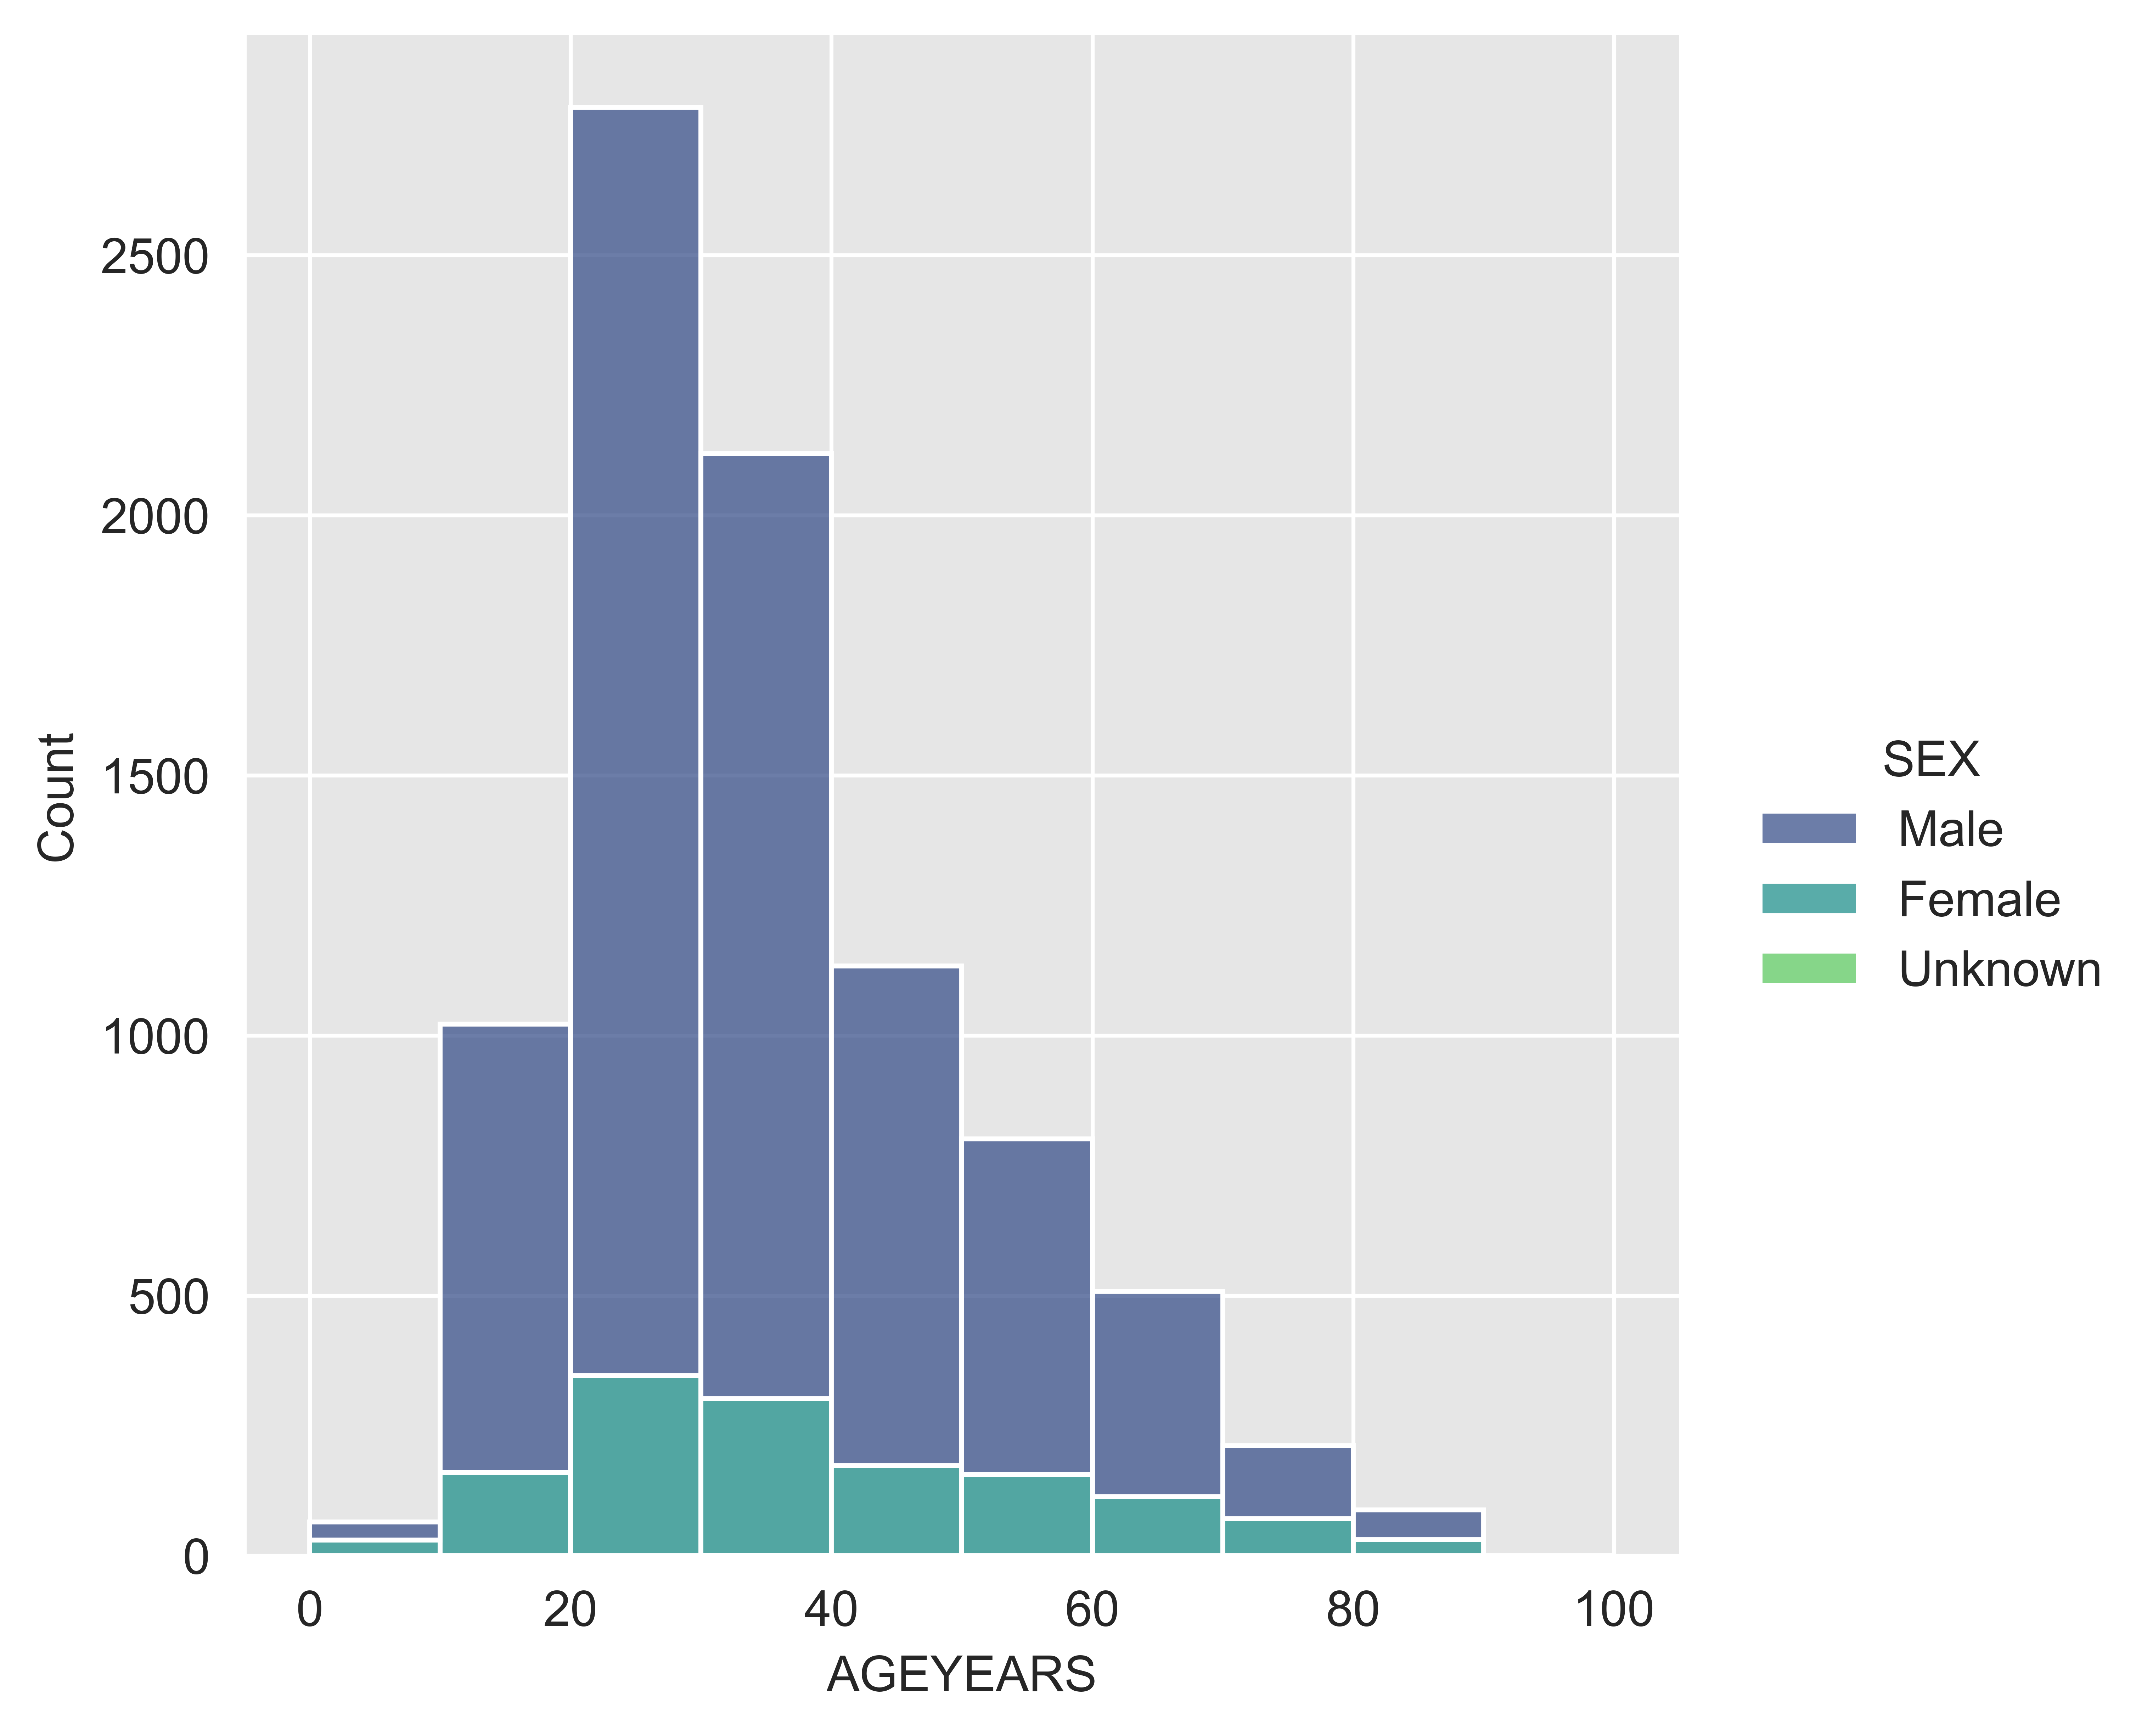

In [64]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)

g = sns.displot(data=TRAUMA_all_df,
               x='AGEYEARS',
               hue='SEX',
               stat='count',
               binwidth=10,
               binrange=(0,100),
               palette='viridis',
               multiple='stack')
plt.show()

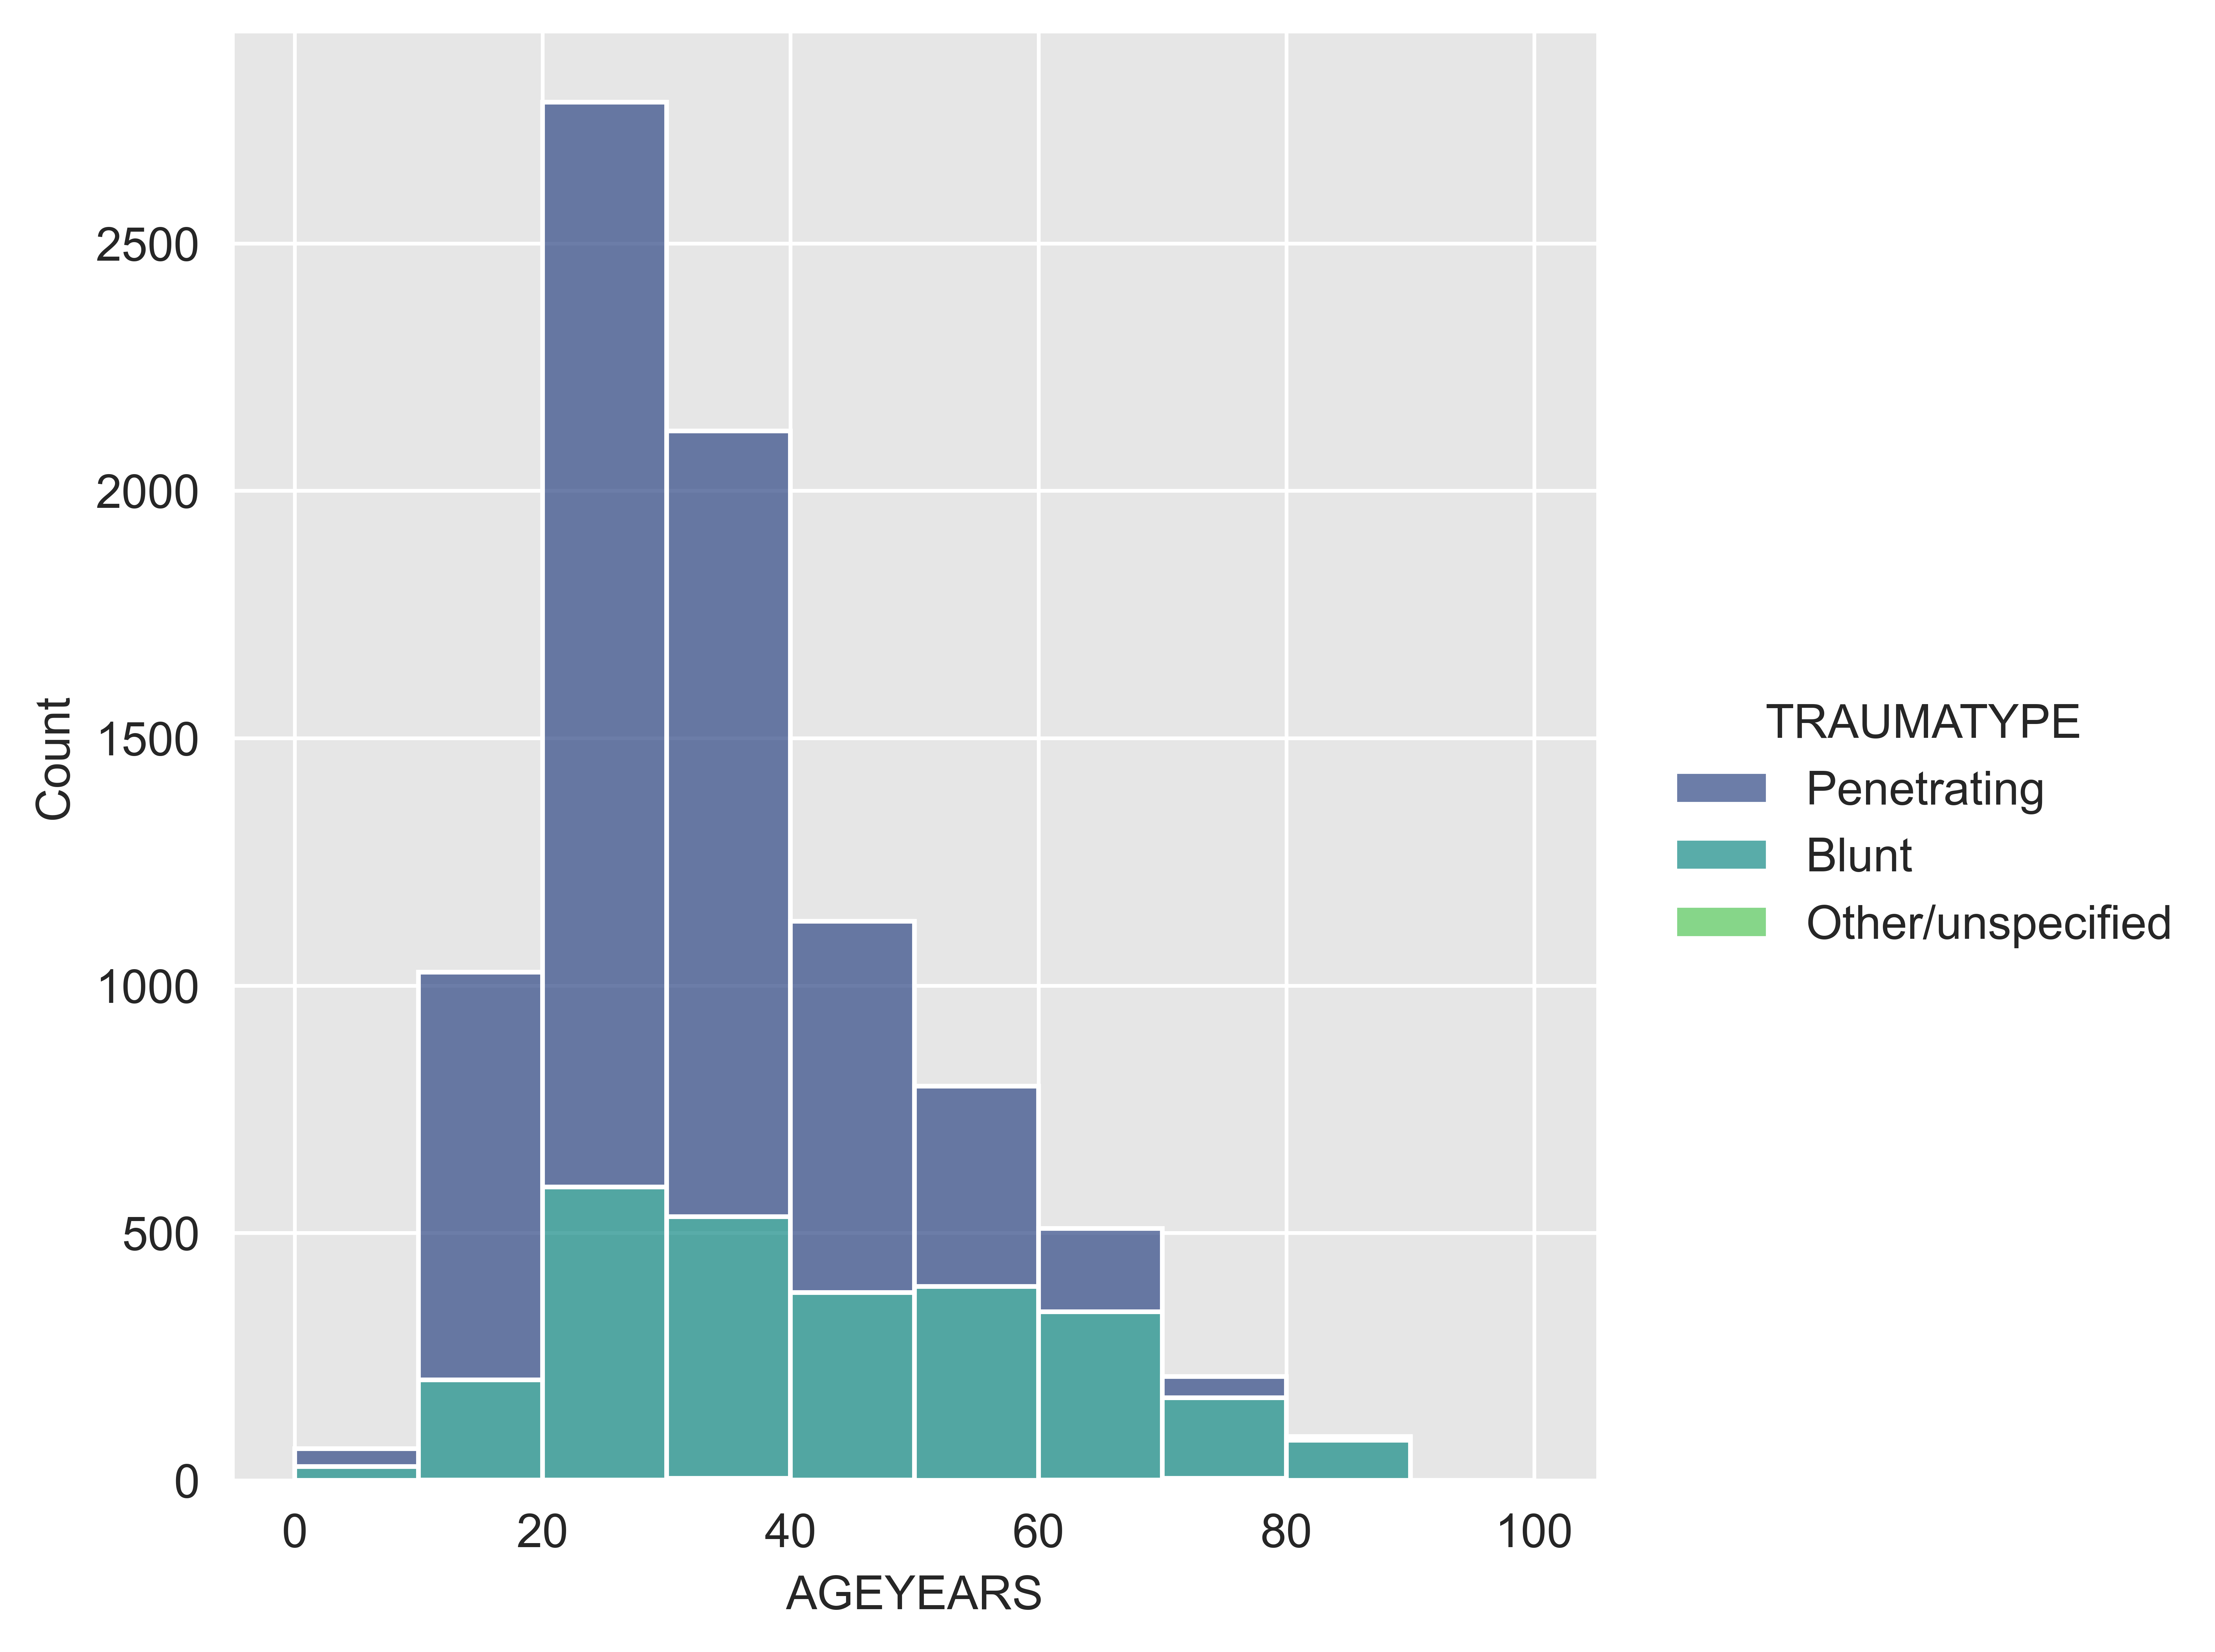

In [65]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)

g = sns.displot(data=TRAUMA_all_df,
               x='AGEYEARS',
               hue='TRAUMATYPE',
               stat='count',
               binwidth=10,
               binrange=(0,100),
               palette='viridis',
               multiple='stack')
plt.show()

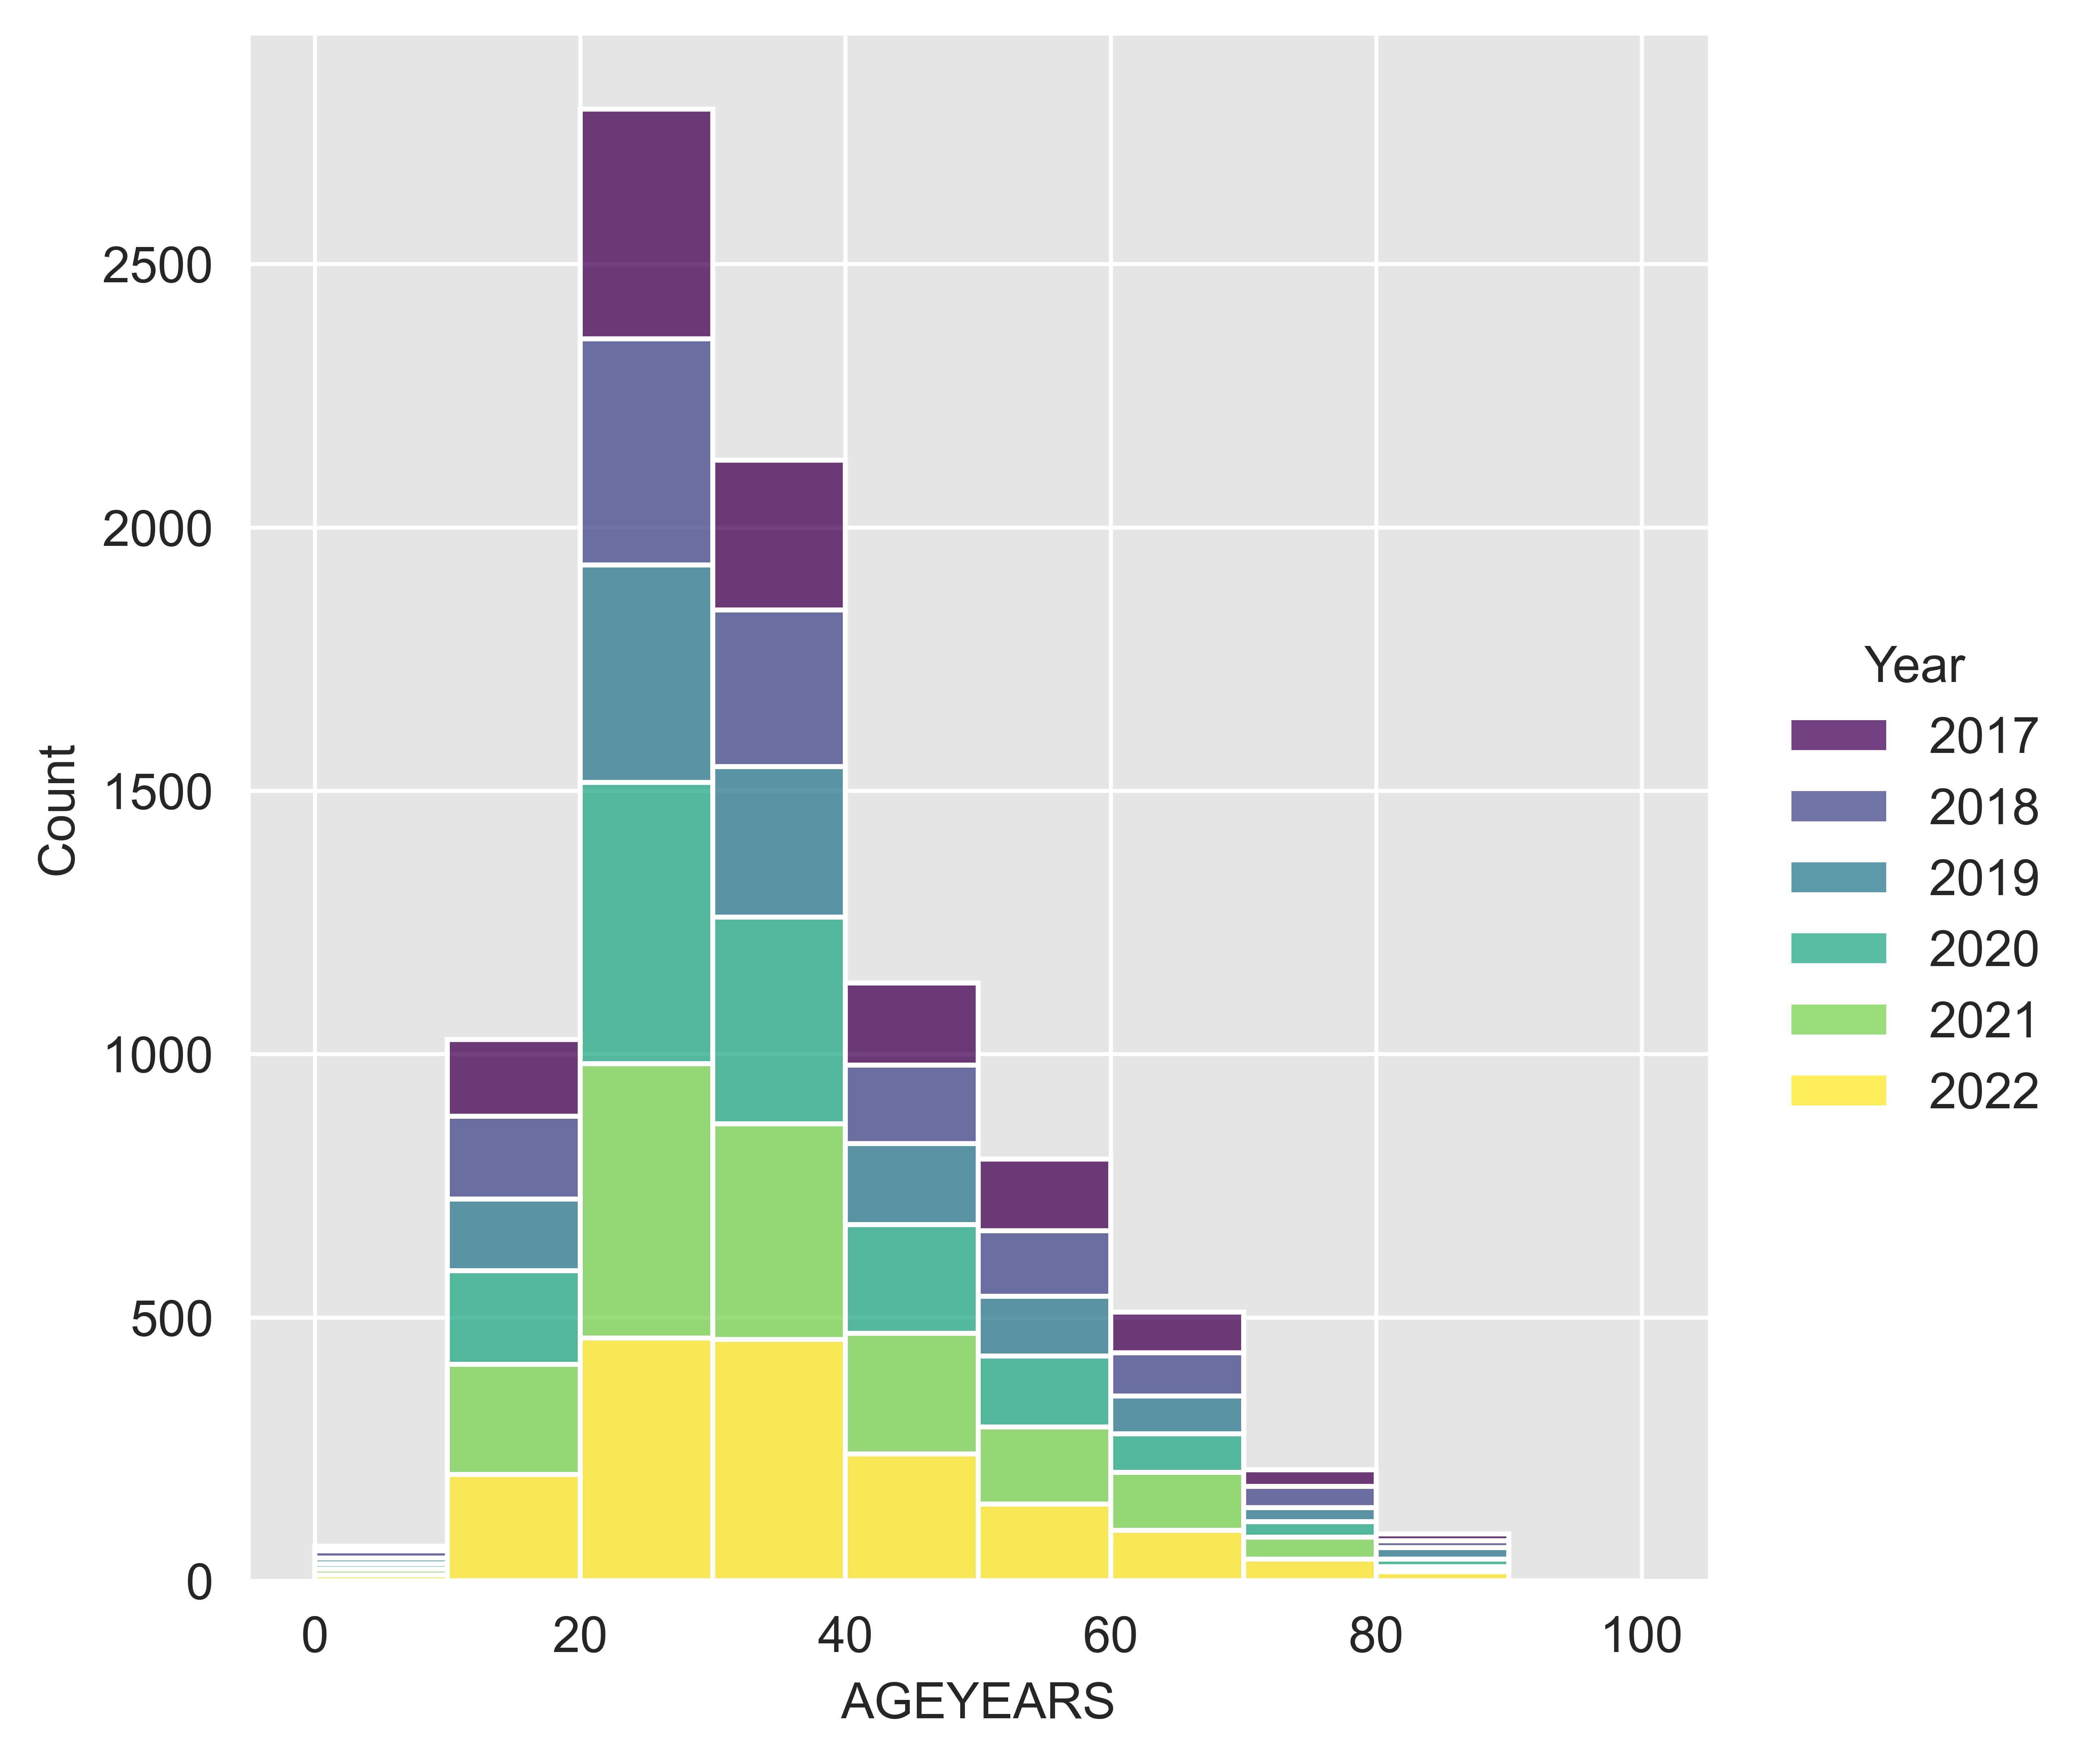

In [66]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)

g = sns.displot(data=TRAUMA_all_df,
               x='AGEYEARS',
               hue='Year',
               stat='count',
               binwidth=10,
               binrange=(0,100),
               palette='viridis',
               multiple='stack')
plt.show()

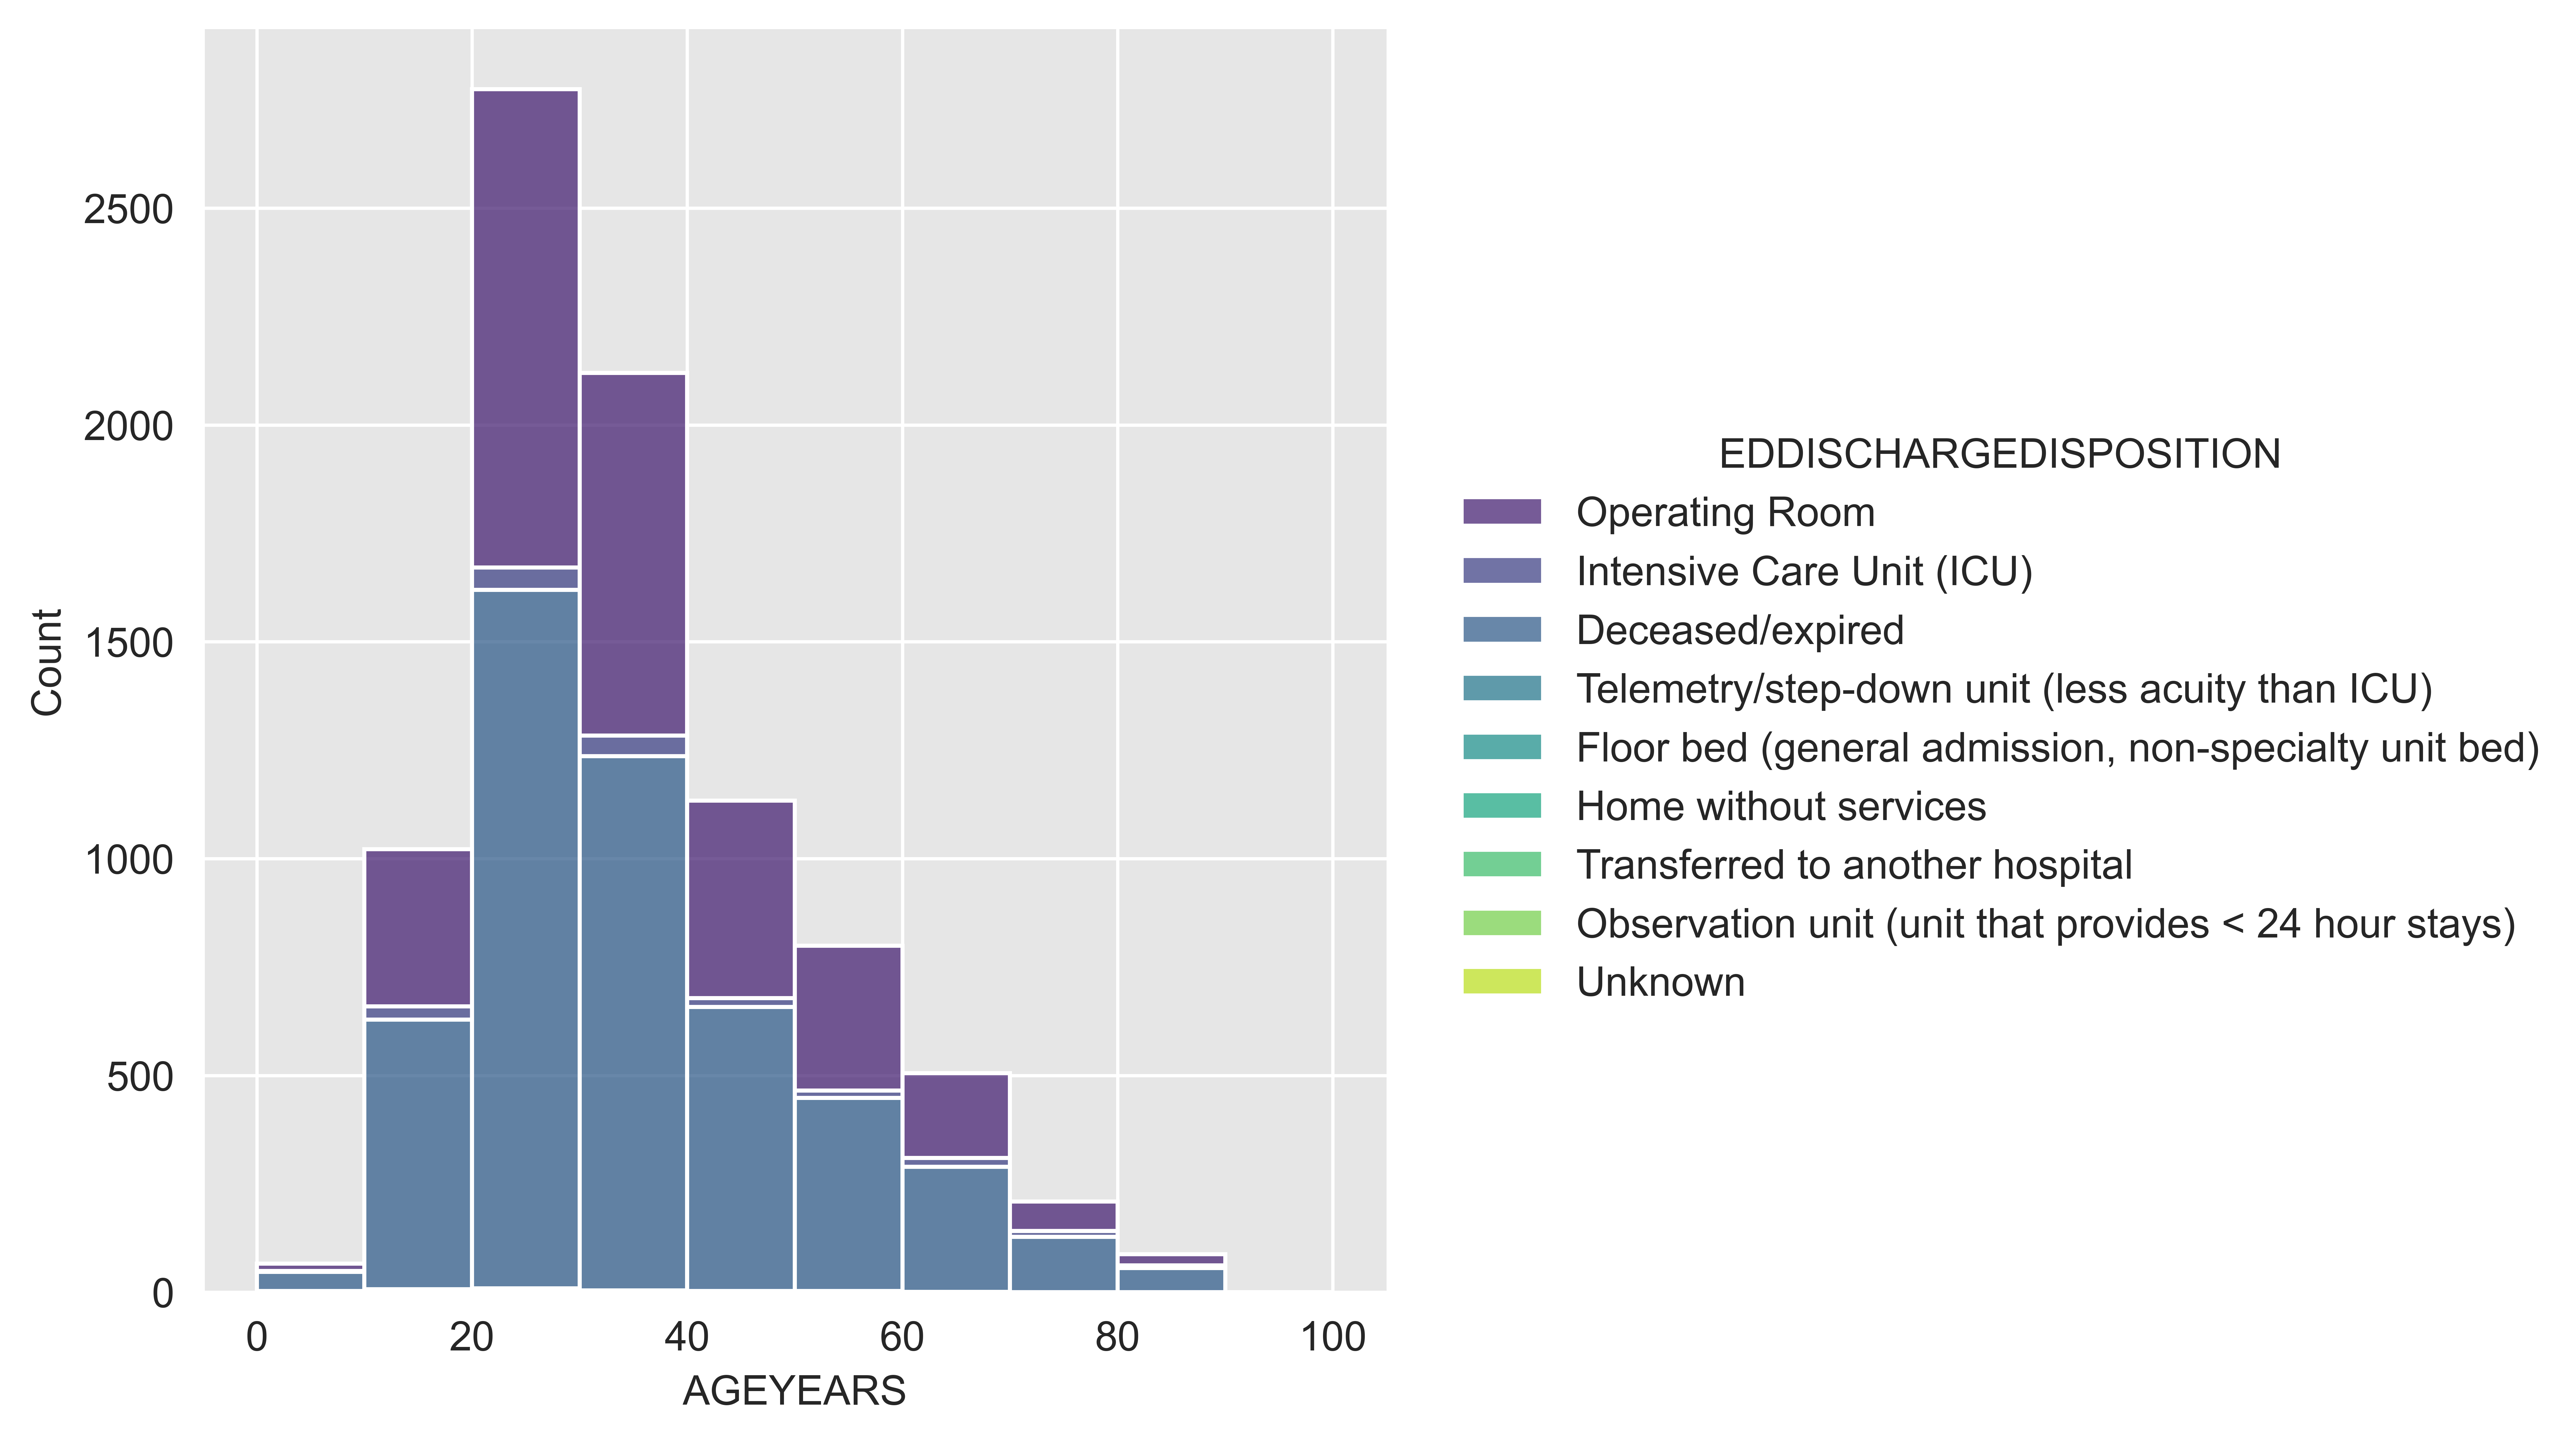

In [67]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)

g = sns.displot(data=TRAUMA_all_df,
               x='AGEYEARS',
               hue='EDDISCHARGEDISPOSITION',
               stat='count',
               binwidth=10,
               binrange=(0,100),
               palette='viridis',
               multiple='stack')
plt.show()

In [68]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)

g = sns.displot(data=TRAUMA_all_df,
               x='AGEYEARS',
               hue='HOSPDISCHARGEDISPOSITION',
               stat='count',
               binwidth=10,
               binrange=(0,100),
               palette='viridis',
               multiple='stack')
plt.show()

# Data about ICD Procedures (Includes **ALL** Procedures, not just the thoracomies but is only using thoracotomy patients)

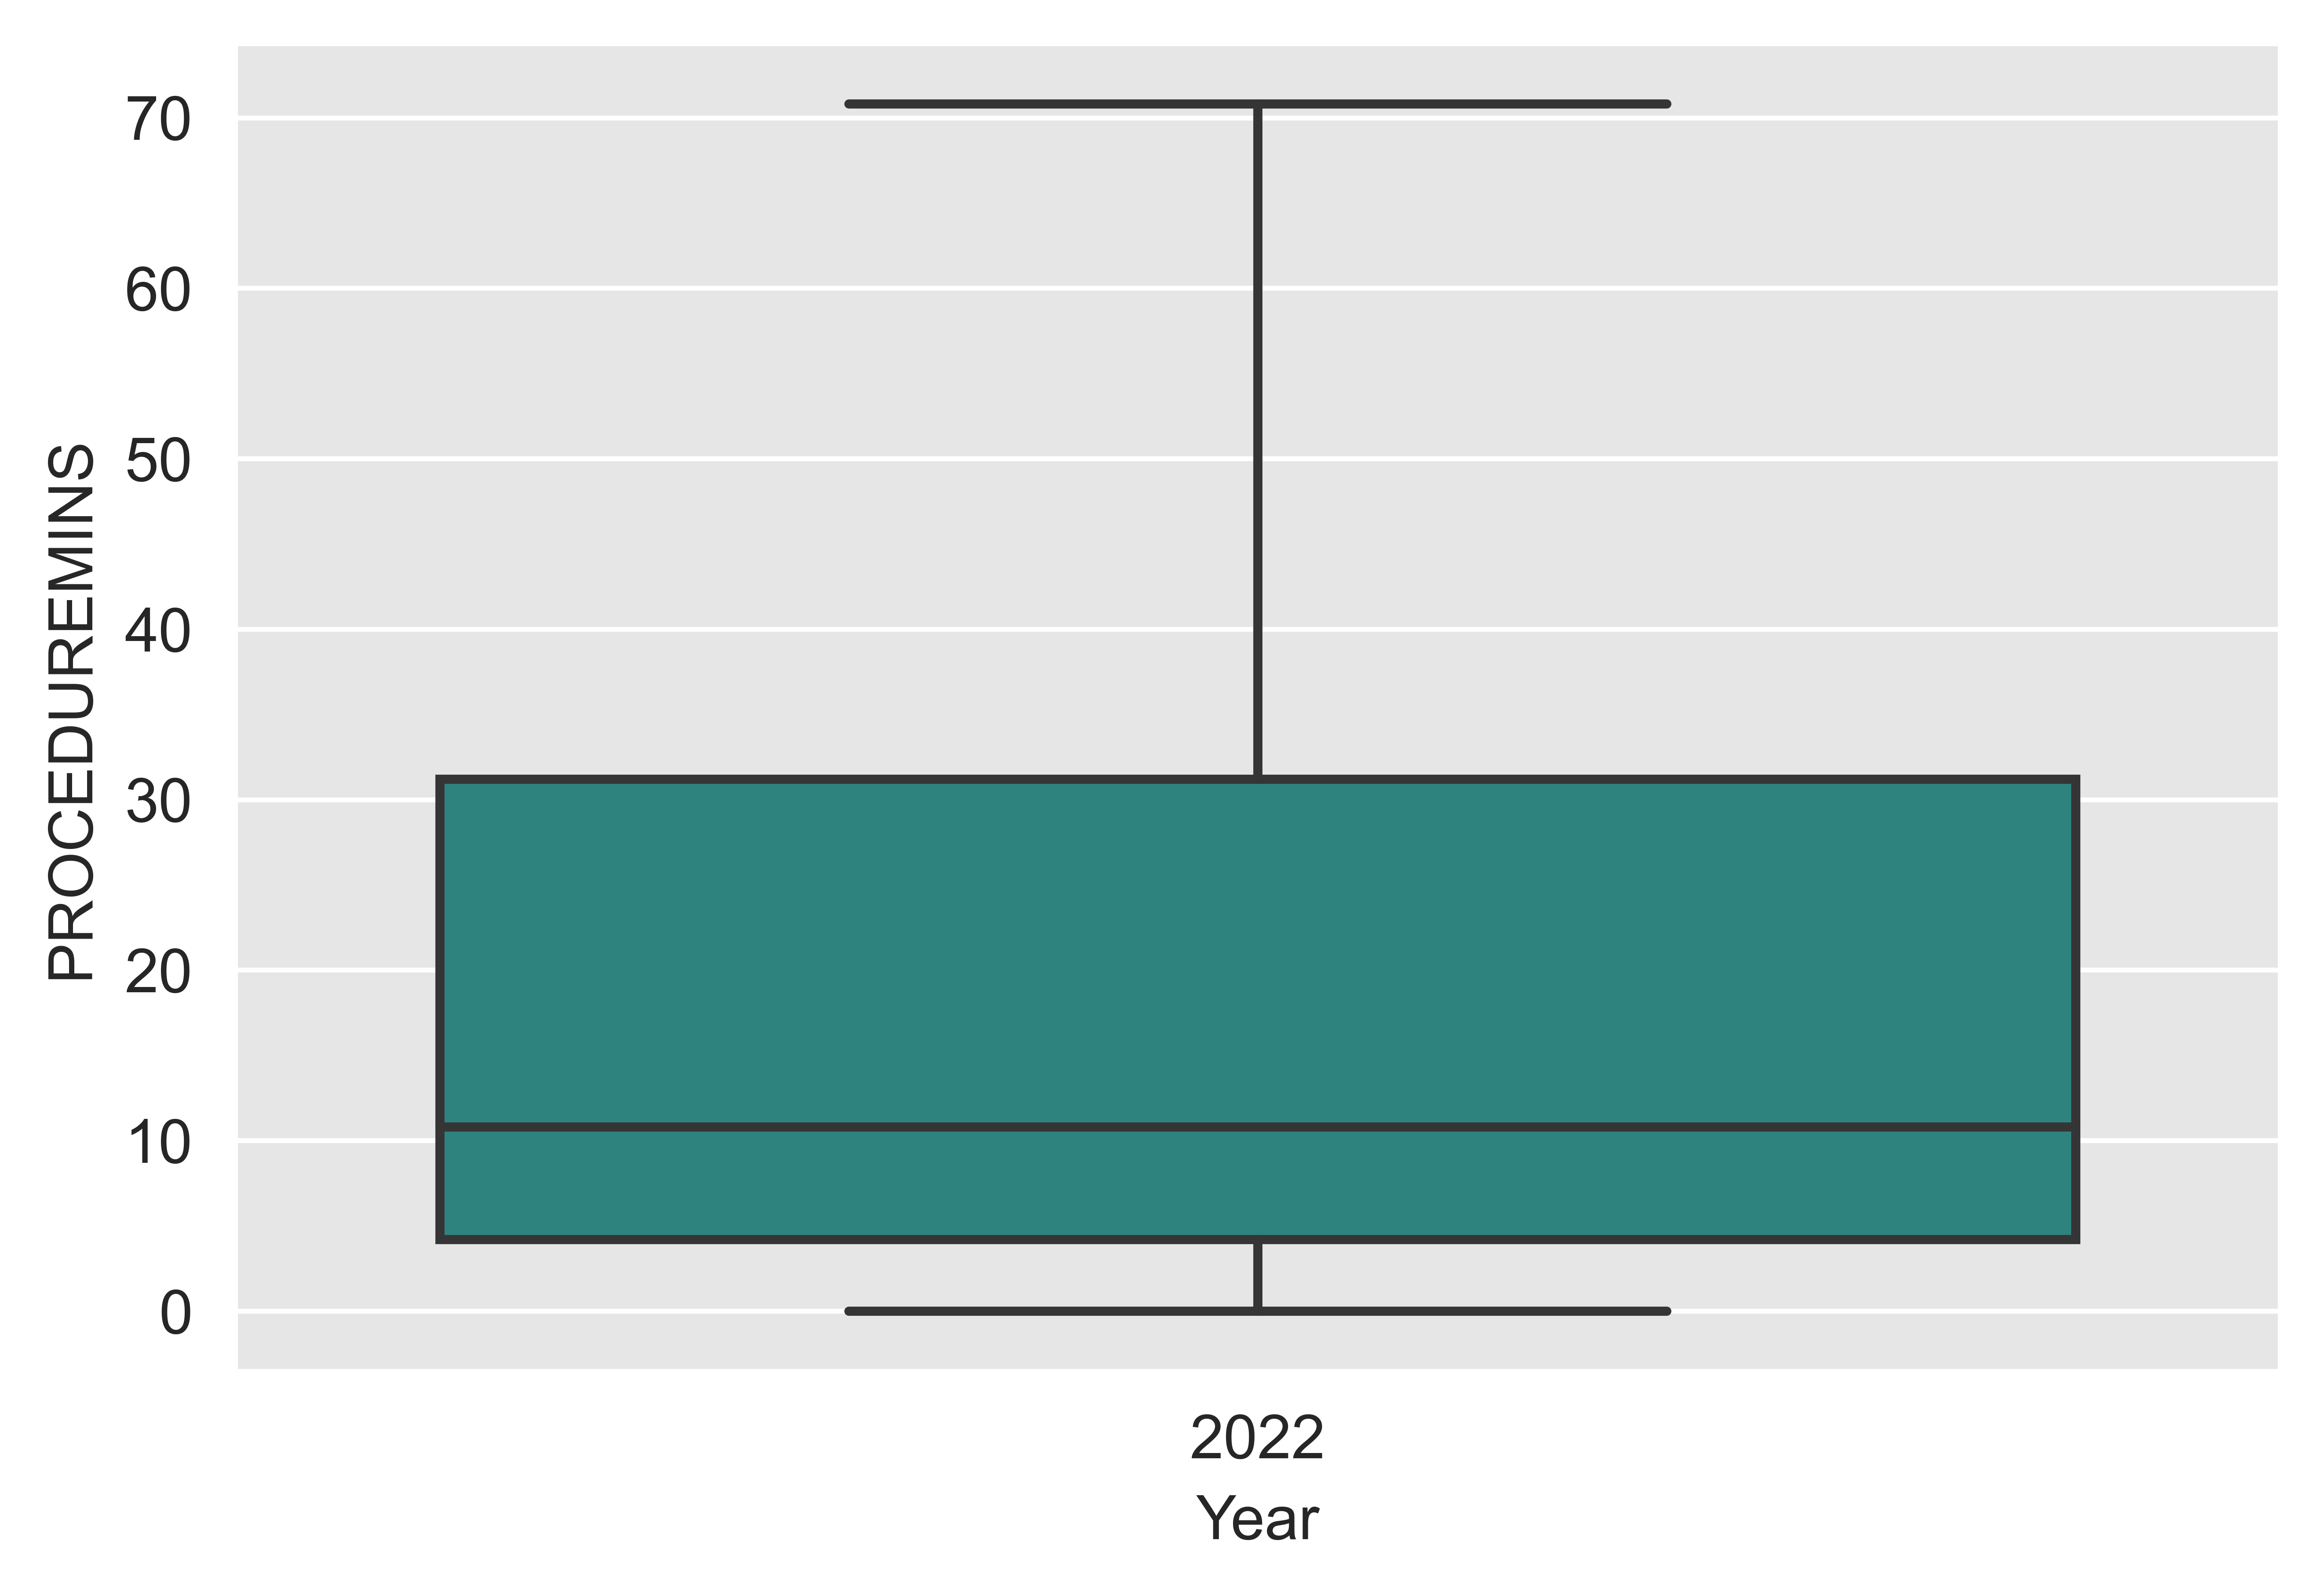

In [69]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)

g = sns.boxplot(data=ICDPROCEDURE_all_df,
               y='PROCEDUREMINS',
               x='Year',
               showfliers=False,
               palette='viridis')
plt.show()

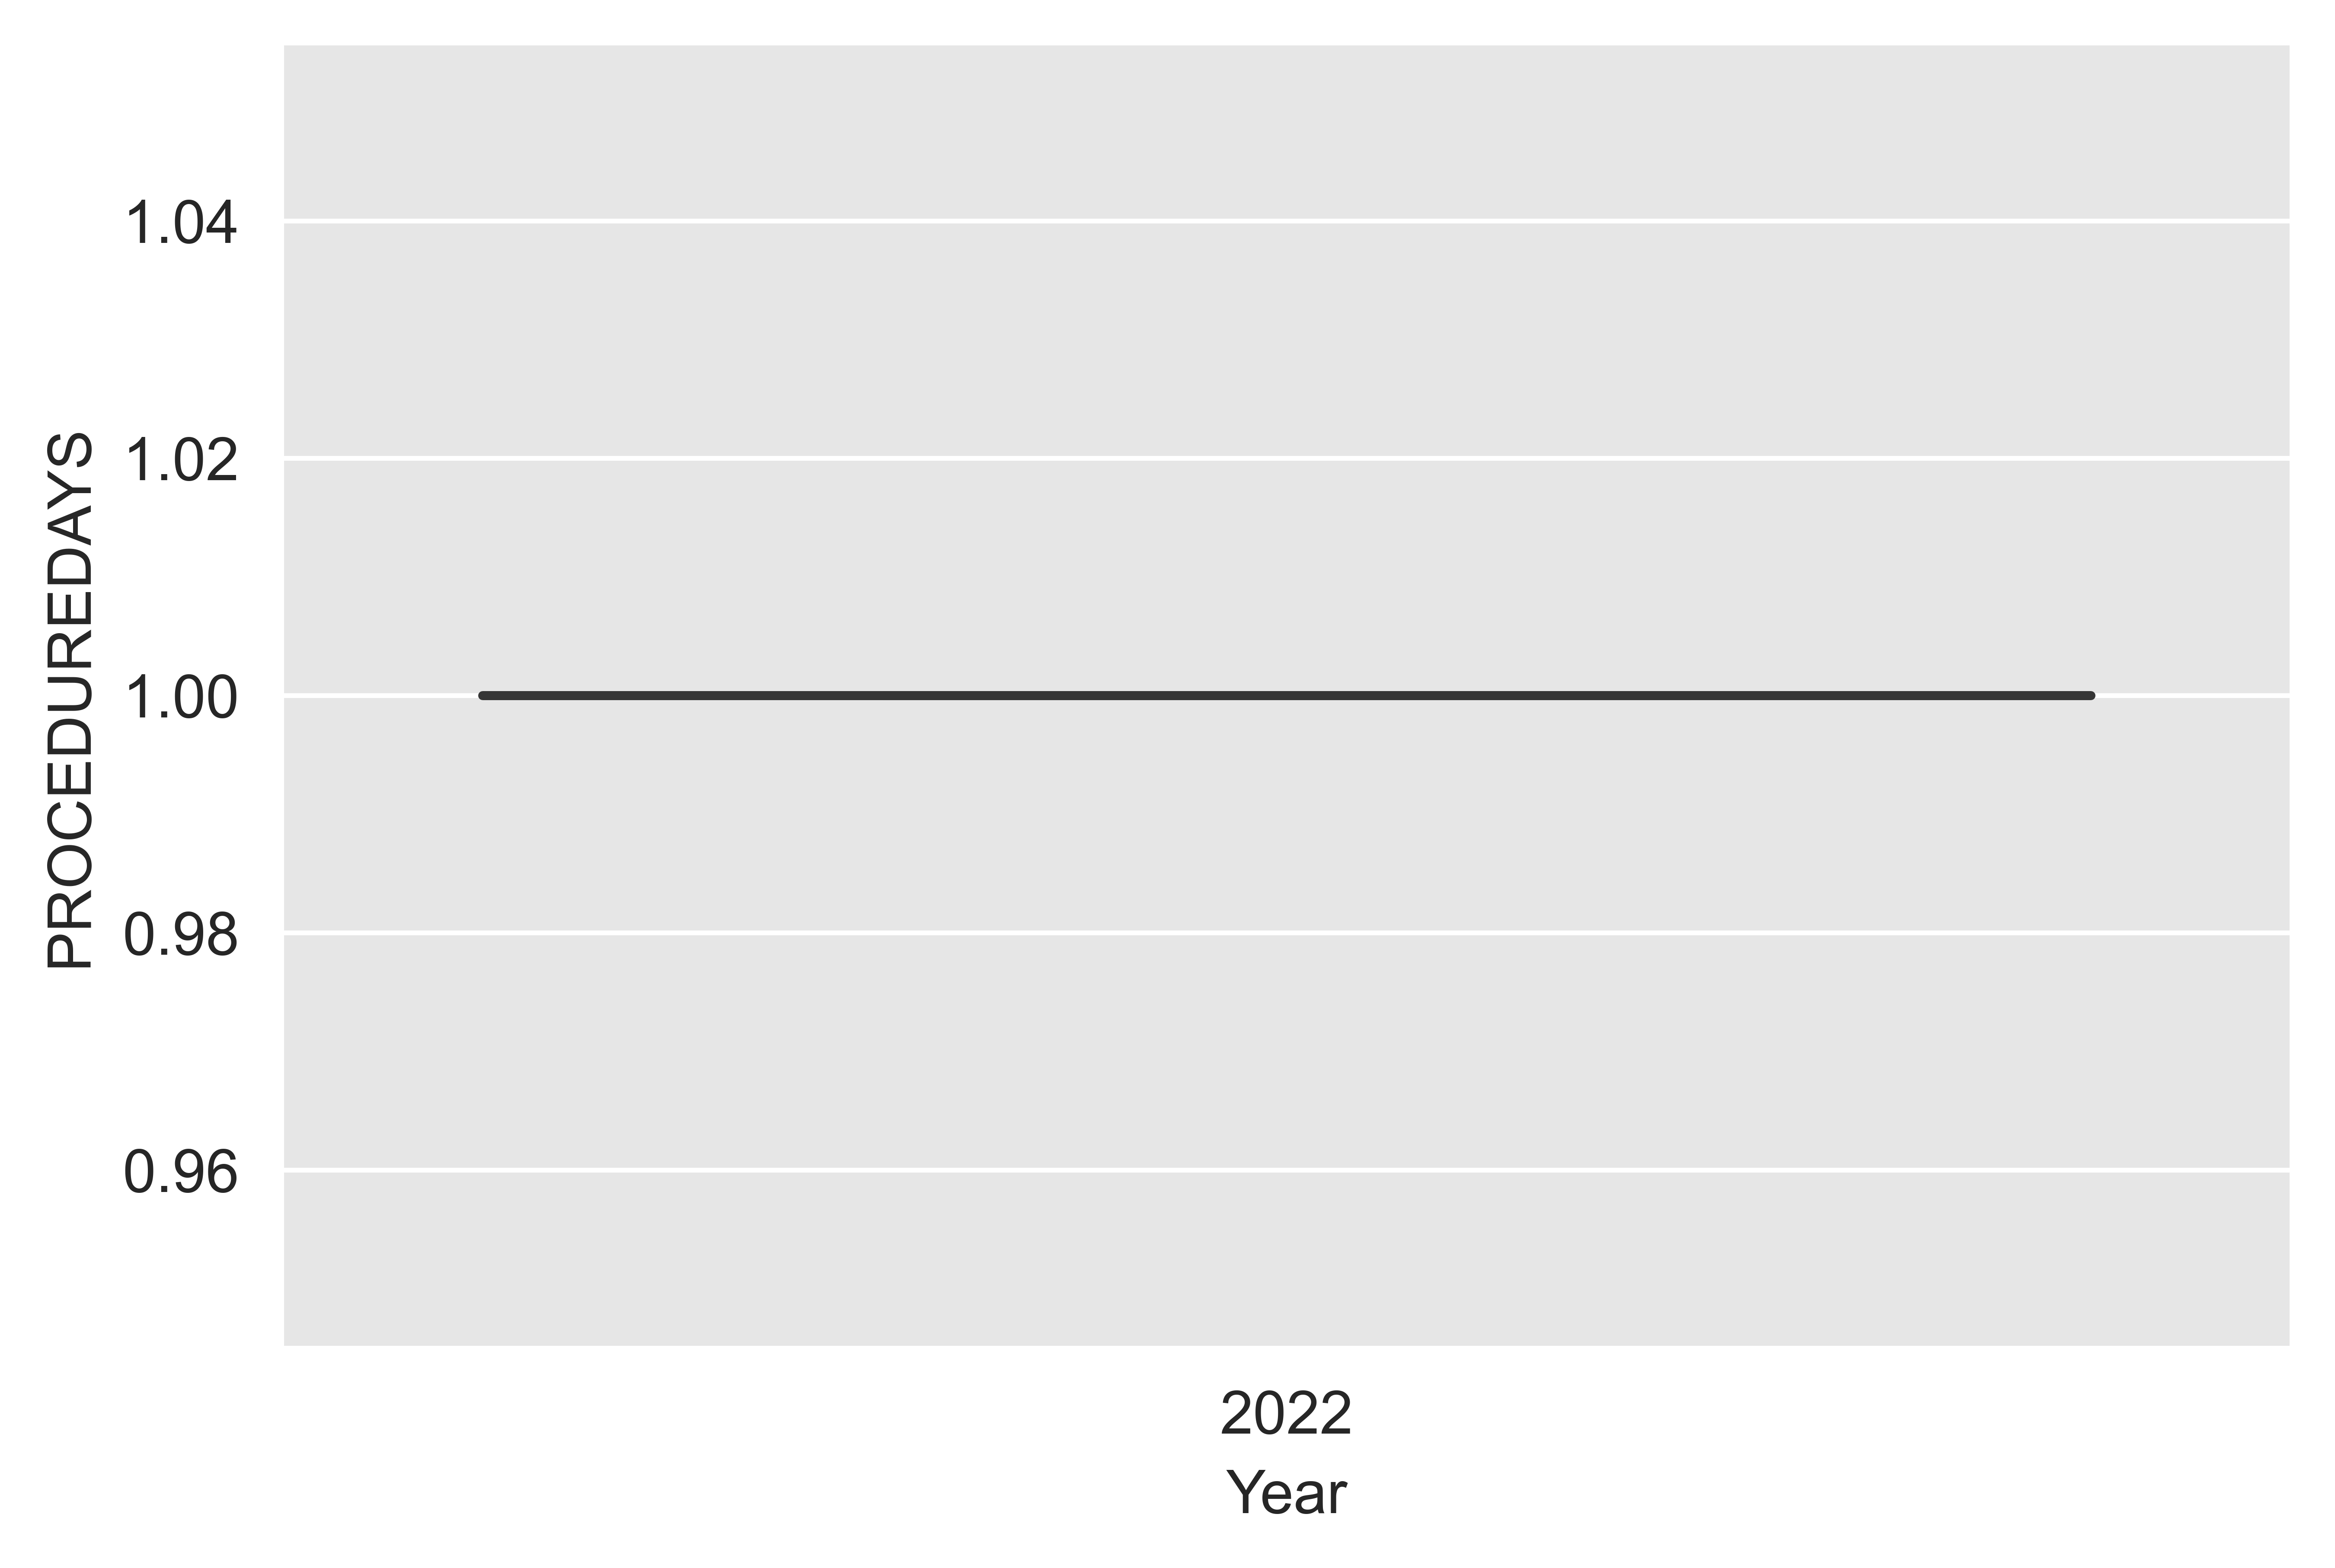

In [70]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)

g = sns.boxplot(data=ICDPROCEDURE_all_df,
               y='PROCEDUREDAYS',
               x='Year',
               showfliers=False,
               palette='viridis')
plt.show()

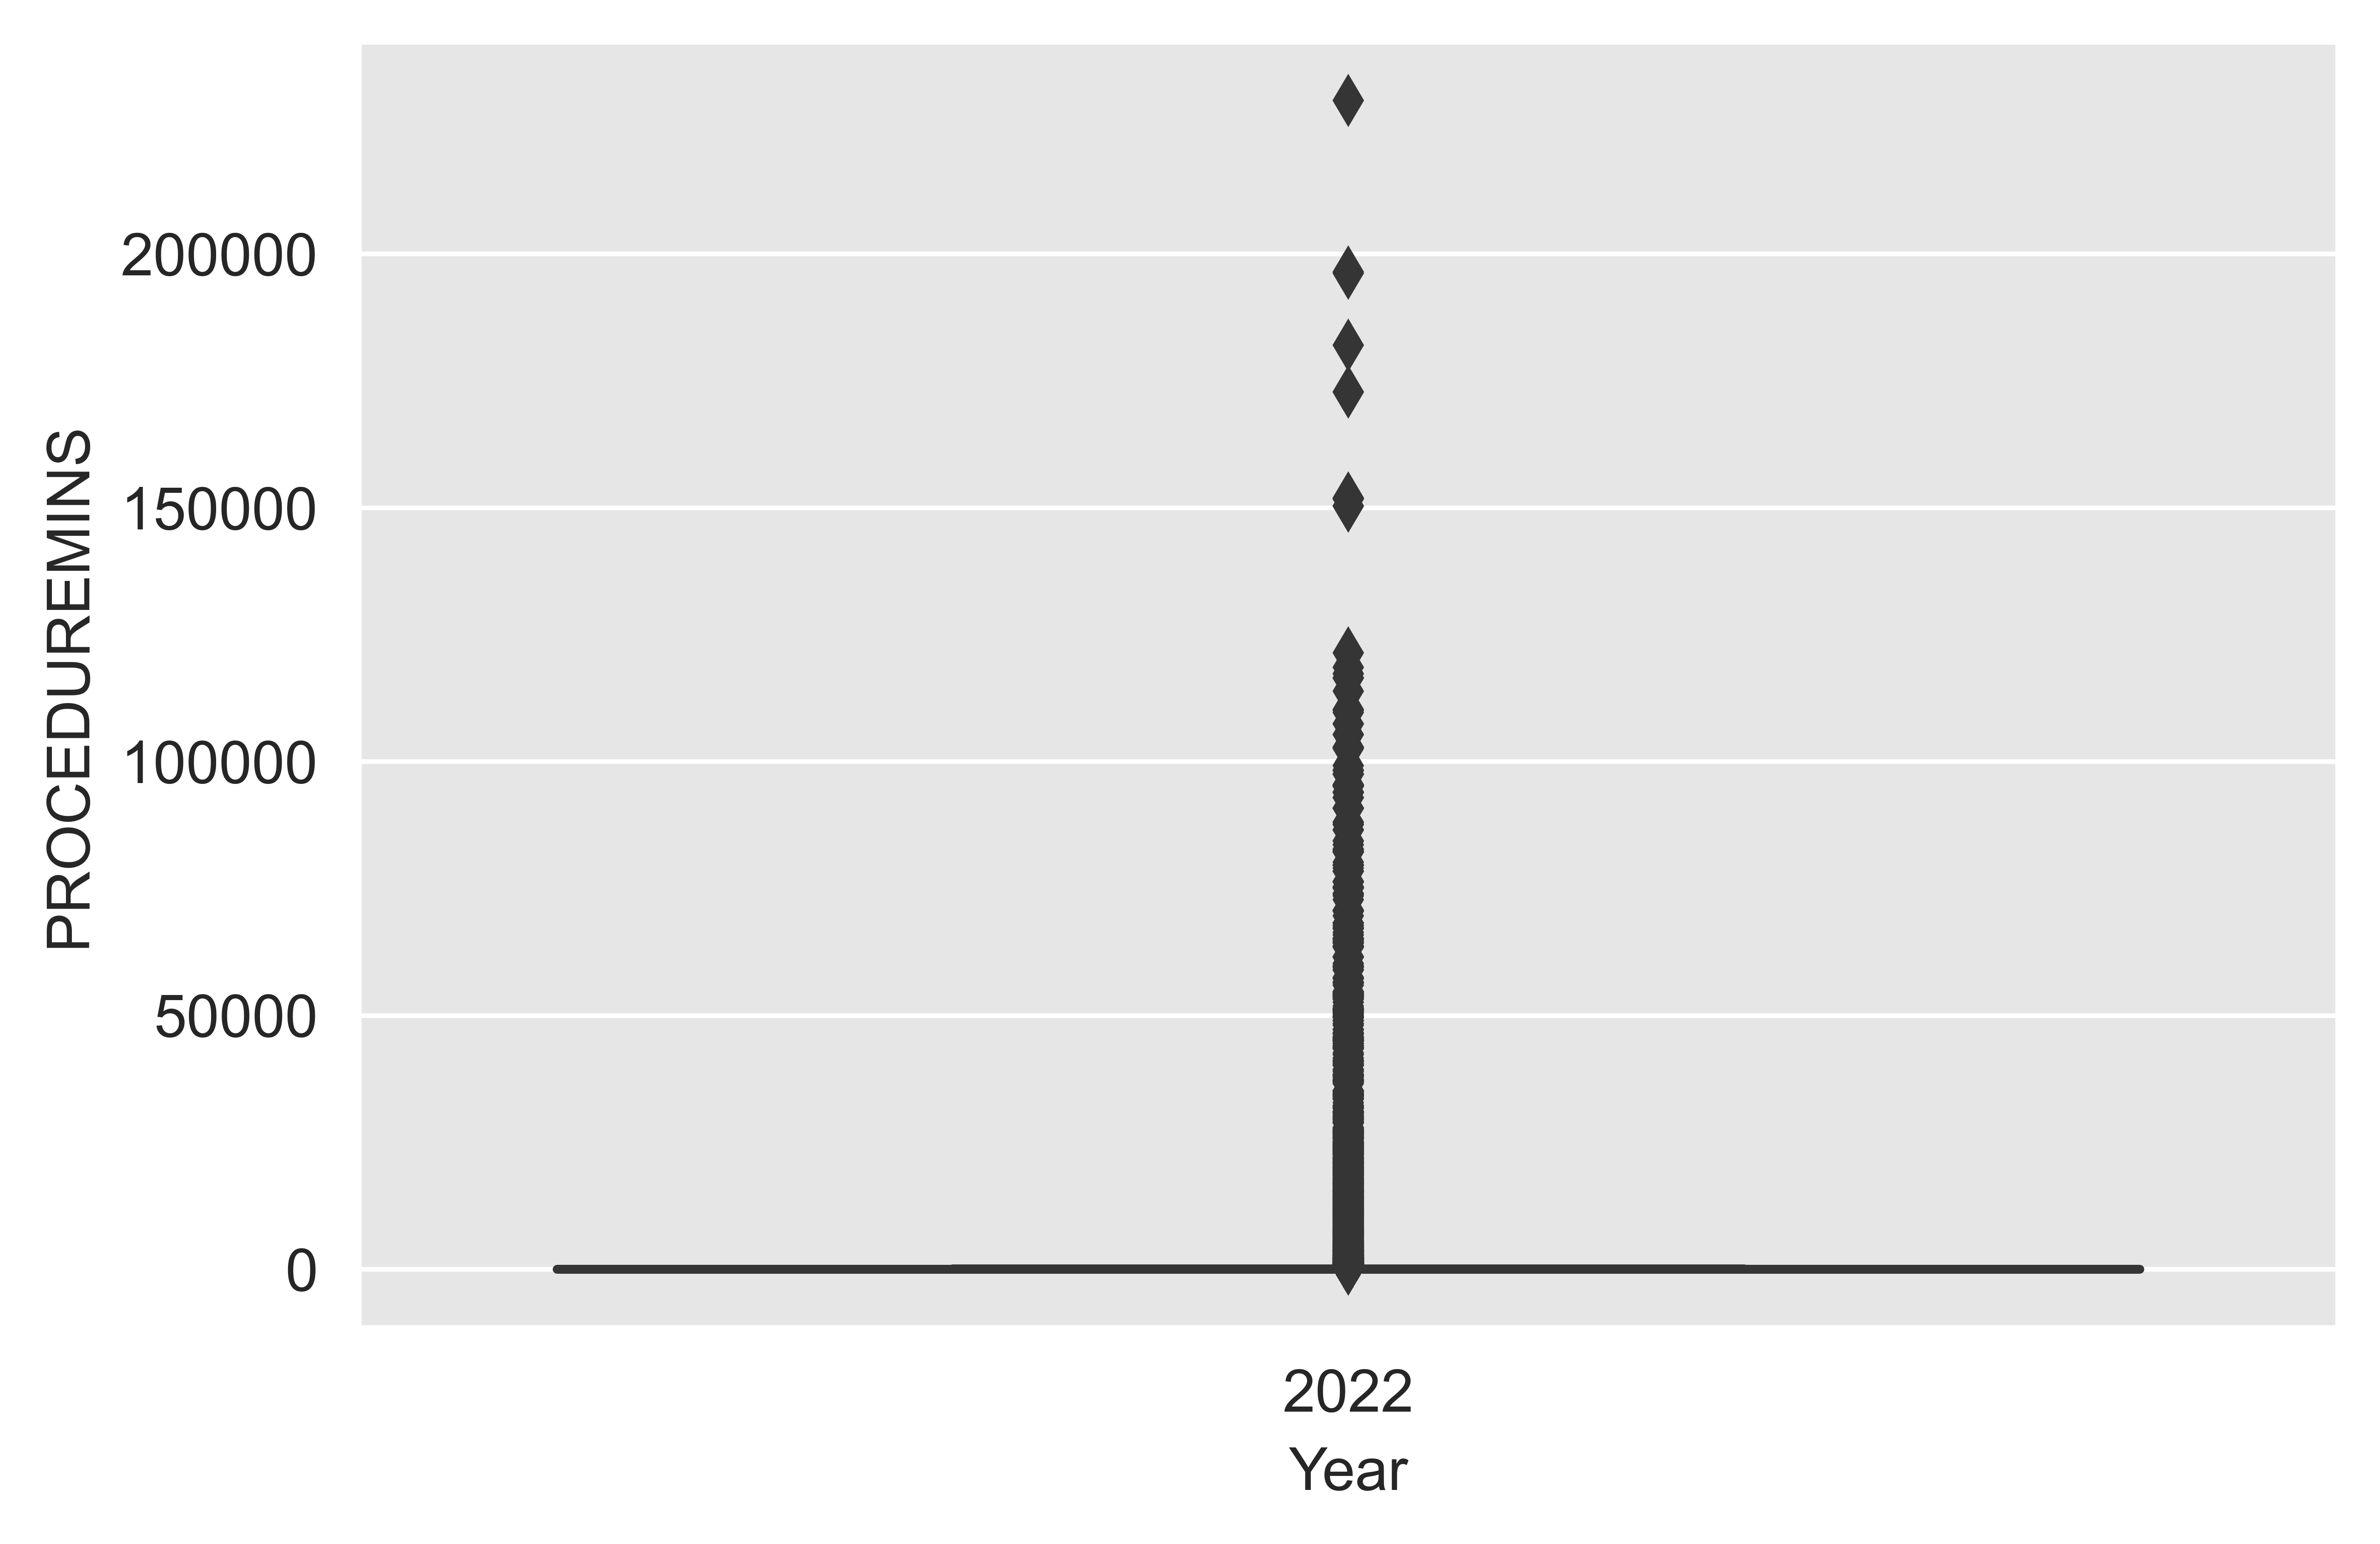

In [71]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)

g = sns.boxplot(data=ICDPROCEDURE_all_df,
               y='PROCEDUREMINS',
               x='Year',
               showfliers=True,
               palette='viridis')
plt.show()

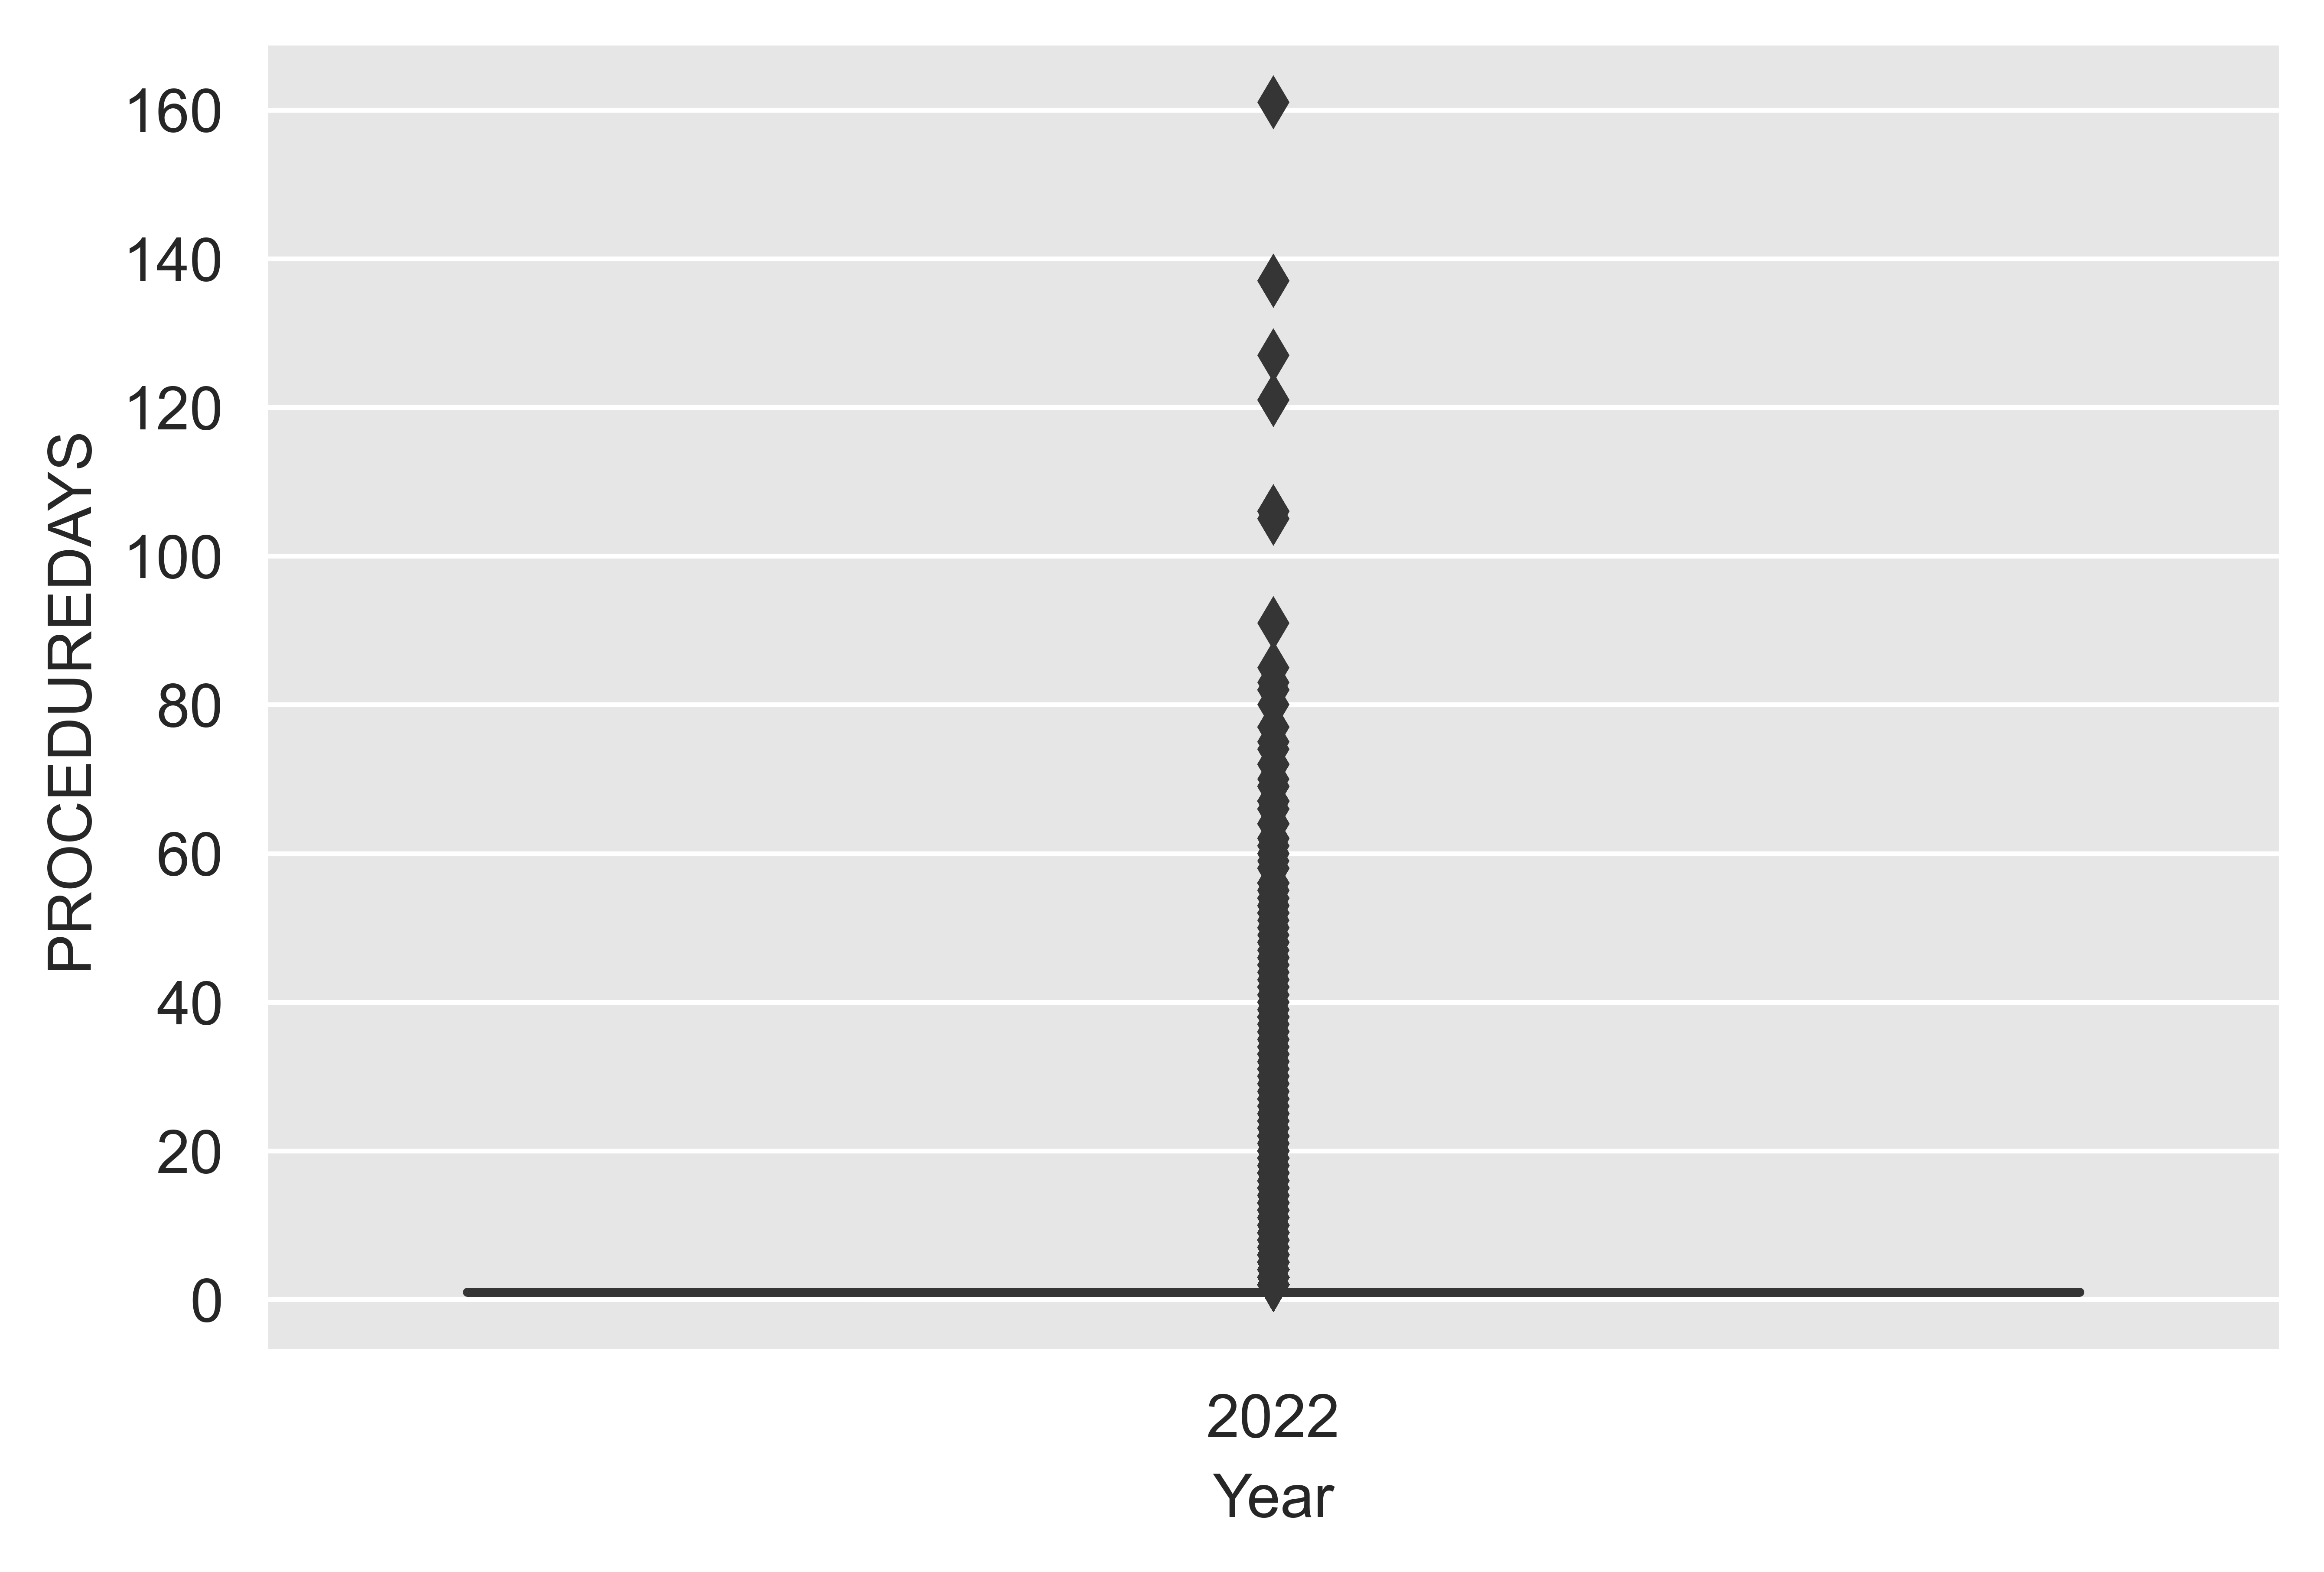

In [72]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)

g = sns.boxplot(data=ICDPROCEDURE_all_df,
               y='PROCEDUREDAYS',
               x='Year',
               showfliers=True,
               palette='viridis')
plt.show()

# Thoracotomy Patients, Only Looking at Procedures We Deemed Directly Thoracotomy Related

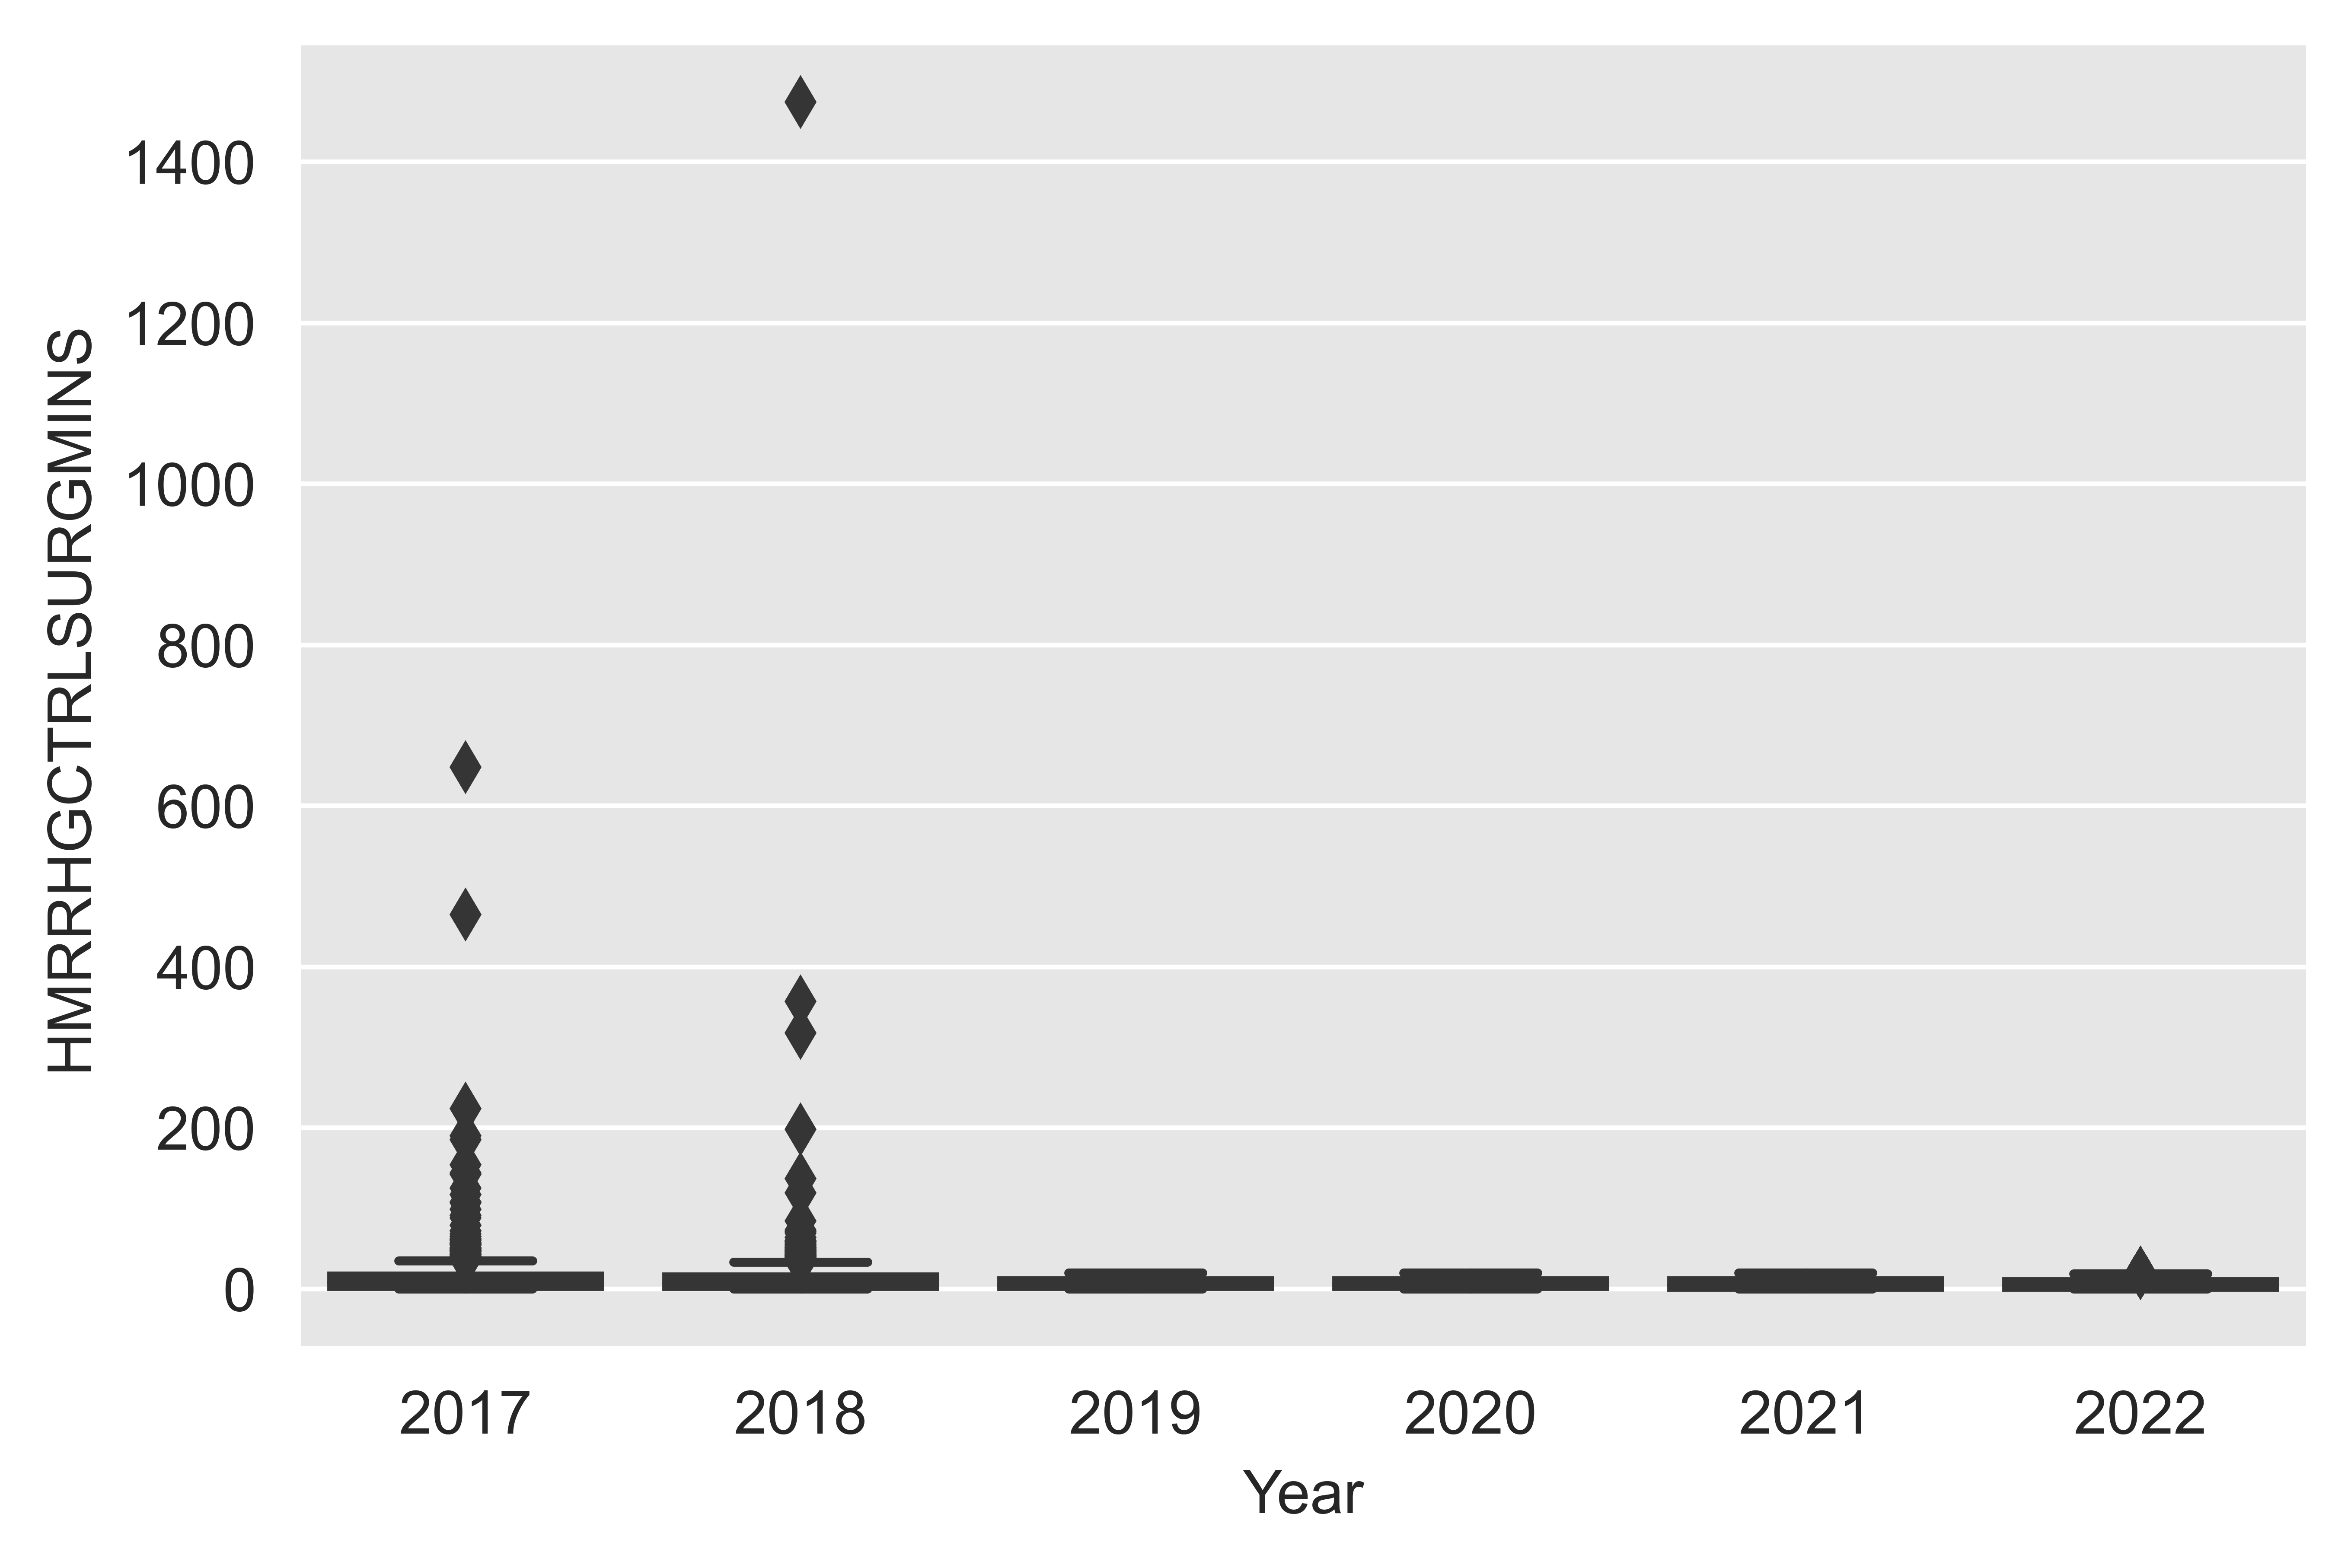

In [73]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)

g = sns.boxplot(data=TRAUMA_all_df,
               y='HMRRHGCTRLSURGMINS',
               x='Year',
               showfliers=True,
               palette='viridis')
plt.show()

> The below figure is obviously uninteresting but validates that the filtering protocols in previous steps at the very least limited the procedures to the thoracotomies performed on the same day as arrival to the ED.

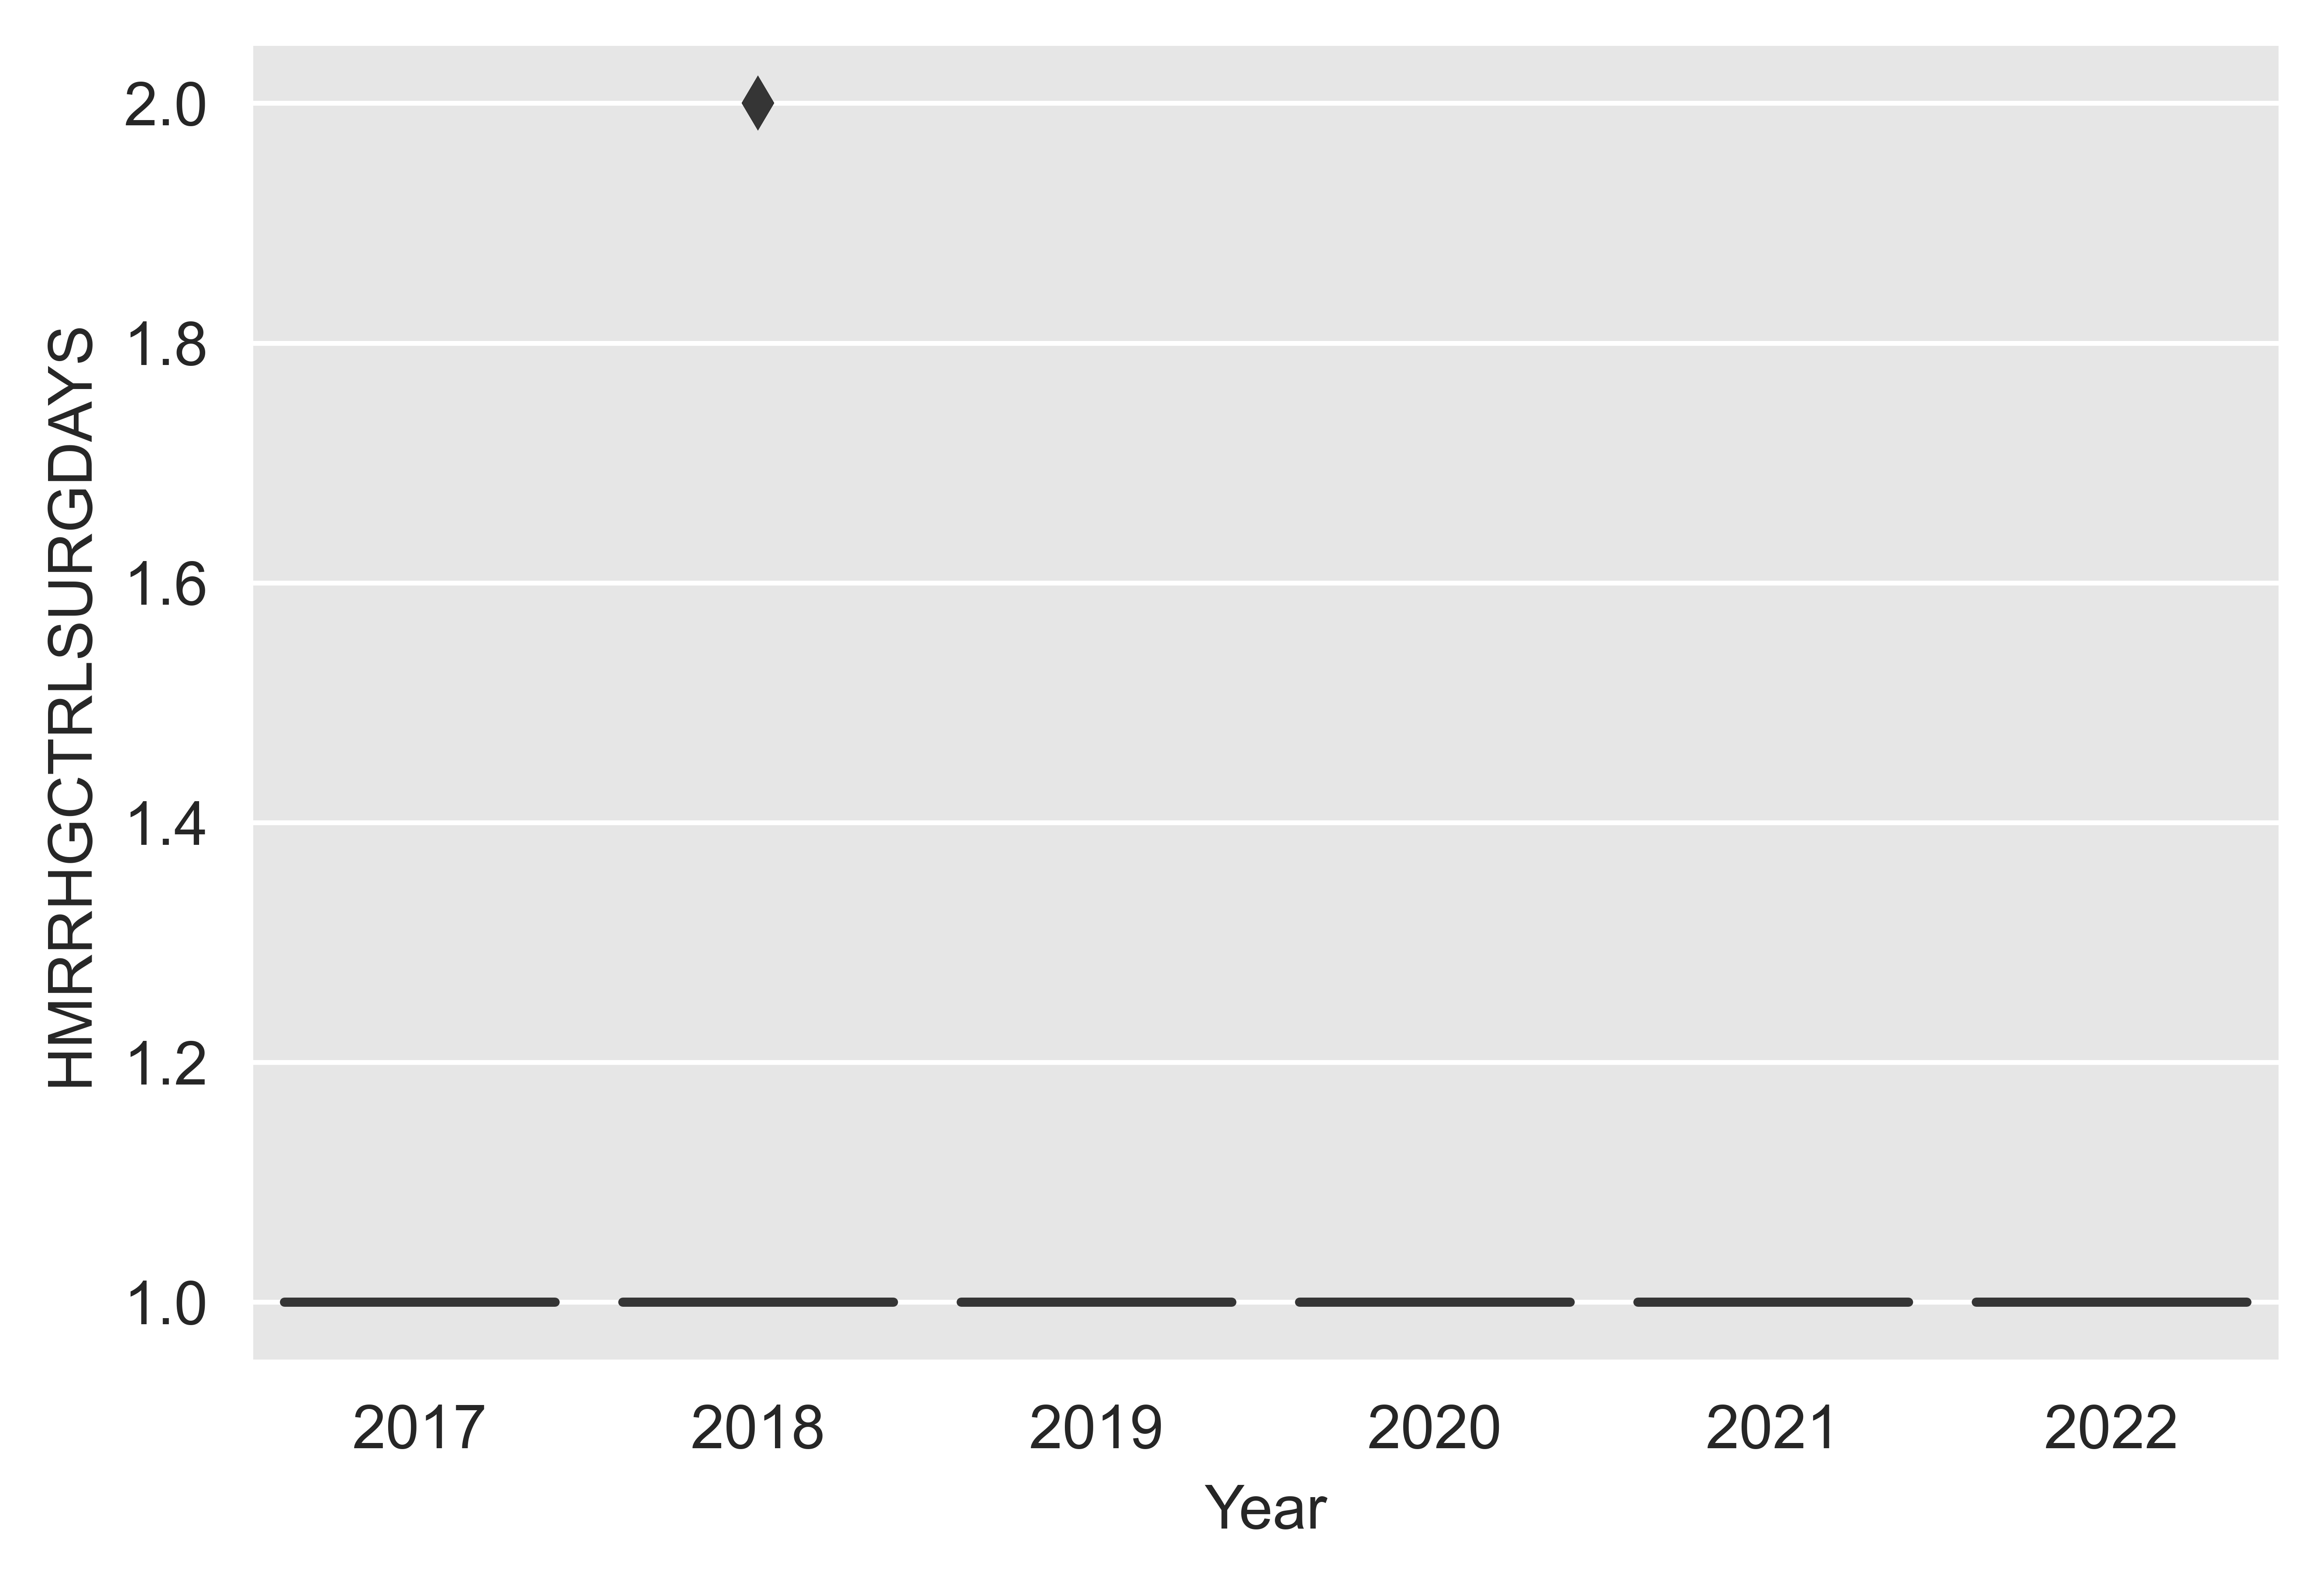

In [74]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)

g = sns.boxplot(data=TRAUMA_all_df,
               y='HMRRHGCTRLSURGDAYS',
               x='Year',
               showfliers=True,
               palette='viridis')
plt.show()

# Within 60 minutes of arrival

In [75]:
mortality_year_table = pd.DataFrame(columns=['Year', 'Mortality %', 'MOI', 'Thoracotomies Performed (Year Total for All MOI)'])
years = range(2017, 2023) # set to year 2016 for max with this part of pipeline
for year in years:
    year_df = TRAUMA_all_df[TRAUMA_all_df['Year'] == year]
    penetrating_df = year_df[year_df['TRAUMATYPE'].isin(['Penetrating'])]
    expired_pen_df1 = penetrating_df[penetrating_df['EDDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
    expired_pen_df2 = penetrating_df[penetrating_df['HOSPDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
    mortality_pen_p = ((np.shape(expired_pen_df1)[0] + np.shape(expired_pen_df2)[0])/np.shape(penetrating_df)[0]) * 100
    blunt_df = year_df[year_df['TRAUMATYPE'].isin(['Blunt'])]
    expired_blunt_df1 = blunt_df[blunt_df['EDDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
    expired_blunt_df2 = blunt_df[blunt_df['HOSPDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
    mortality_blunt_p = ((np.shape(expired_blunt_df1)[0] + np.shape(expired_blunt_df2)[0])/np.shape(blunt_df)[0]) * 100
    final_pen_df = pd.DataFrame([[year, mortality_pen_p, 'Penetrating', np.shape(penetrating_df)[0]]], columns=['Year', 'Mortality %', 'MOI', 'Thoracotomies Performed (Year Total for All MOI)'])
    final_blunt_df = pd.DataFrame([[year, mortality_blunt_p, 'Blunt', np.shape(blunt_df)[0]]], columns=['Year', 'Mortality %', 'MOI', 'Thoracotomies Performed (Year Total for All MOI)'])
    combined_df = pd.DataFrame(np.vstack((final_pen_df, final_blunt_df)), columns=['Year', 'Mortality %', 'MOI', 'Thoracotomies Performed (Year Total for All MOI)'])
    mortality_year_table = pd.concat([mortality_year_table, combined_df])
mortality_year_table['Mortality %'] = mortality_year_table['Mortality %'].astype(float)
mortality_year_table['Year'] = mortality_year_table['Year'].astype(int)
display(mortality_year_table)

Year  Mortality %          MOI  \
0  2017    85.442329  Penetrating   
1  2017    92.893401        Blunt   
0  2018    89.786756  Penetrating   
1  2018    91.646192        Blunt   
0  2019    89.629630  Penetrating   
1  2019    94.927536        Blunt   
0  2020    91.083916  Penetrating   
1  2020    93.853428        Blunt   
0  2021    90.500864  Penetrating   
1  2021    93.893130        Blunt   
0  2022    91.860465  Penetrating   
1  2022    97.058824        Blunt   

  Thoracotomies Performed (Year Total for All MOI)  
0                                              893  
1                                              394  
0                                              891  
1                                              407  
0                                              810  
1                                              414  
0                                             1144  
1                                              423  
0                                             1158  
1                                              524  
0                                             1118  
1                                              544

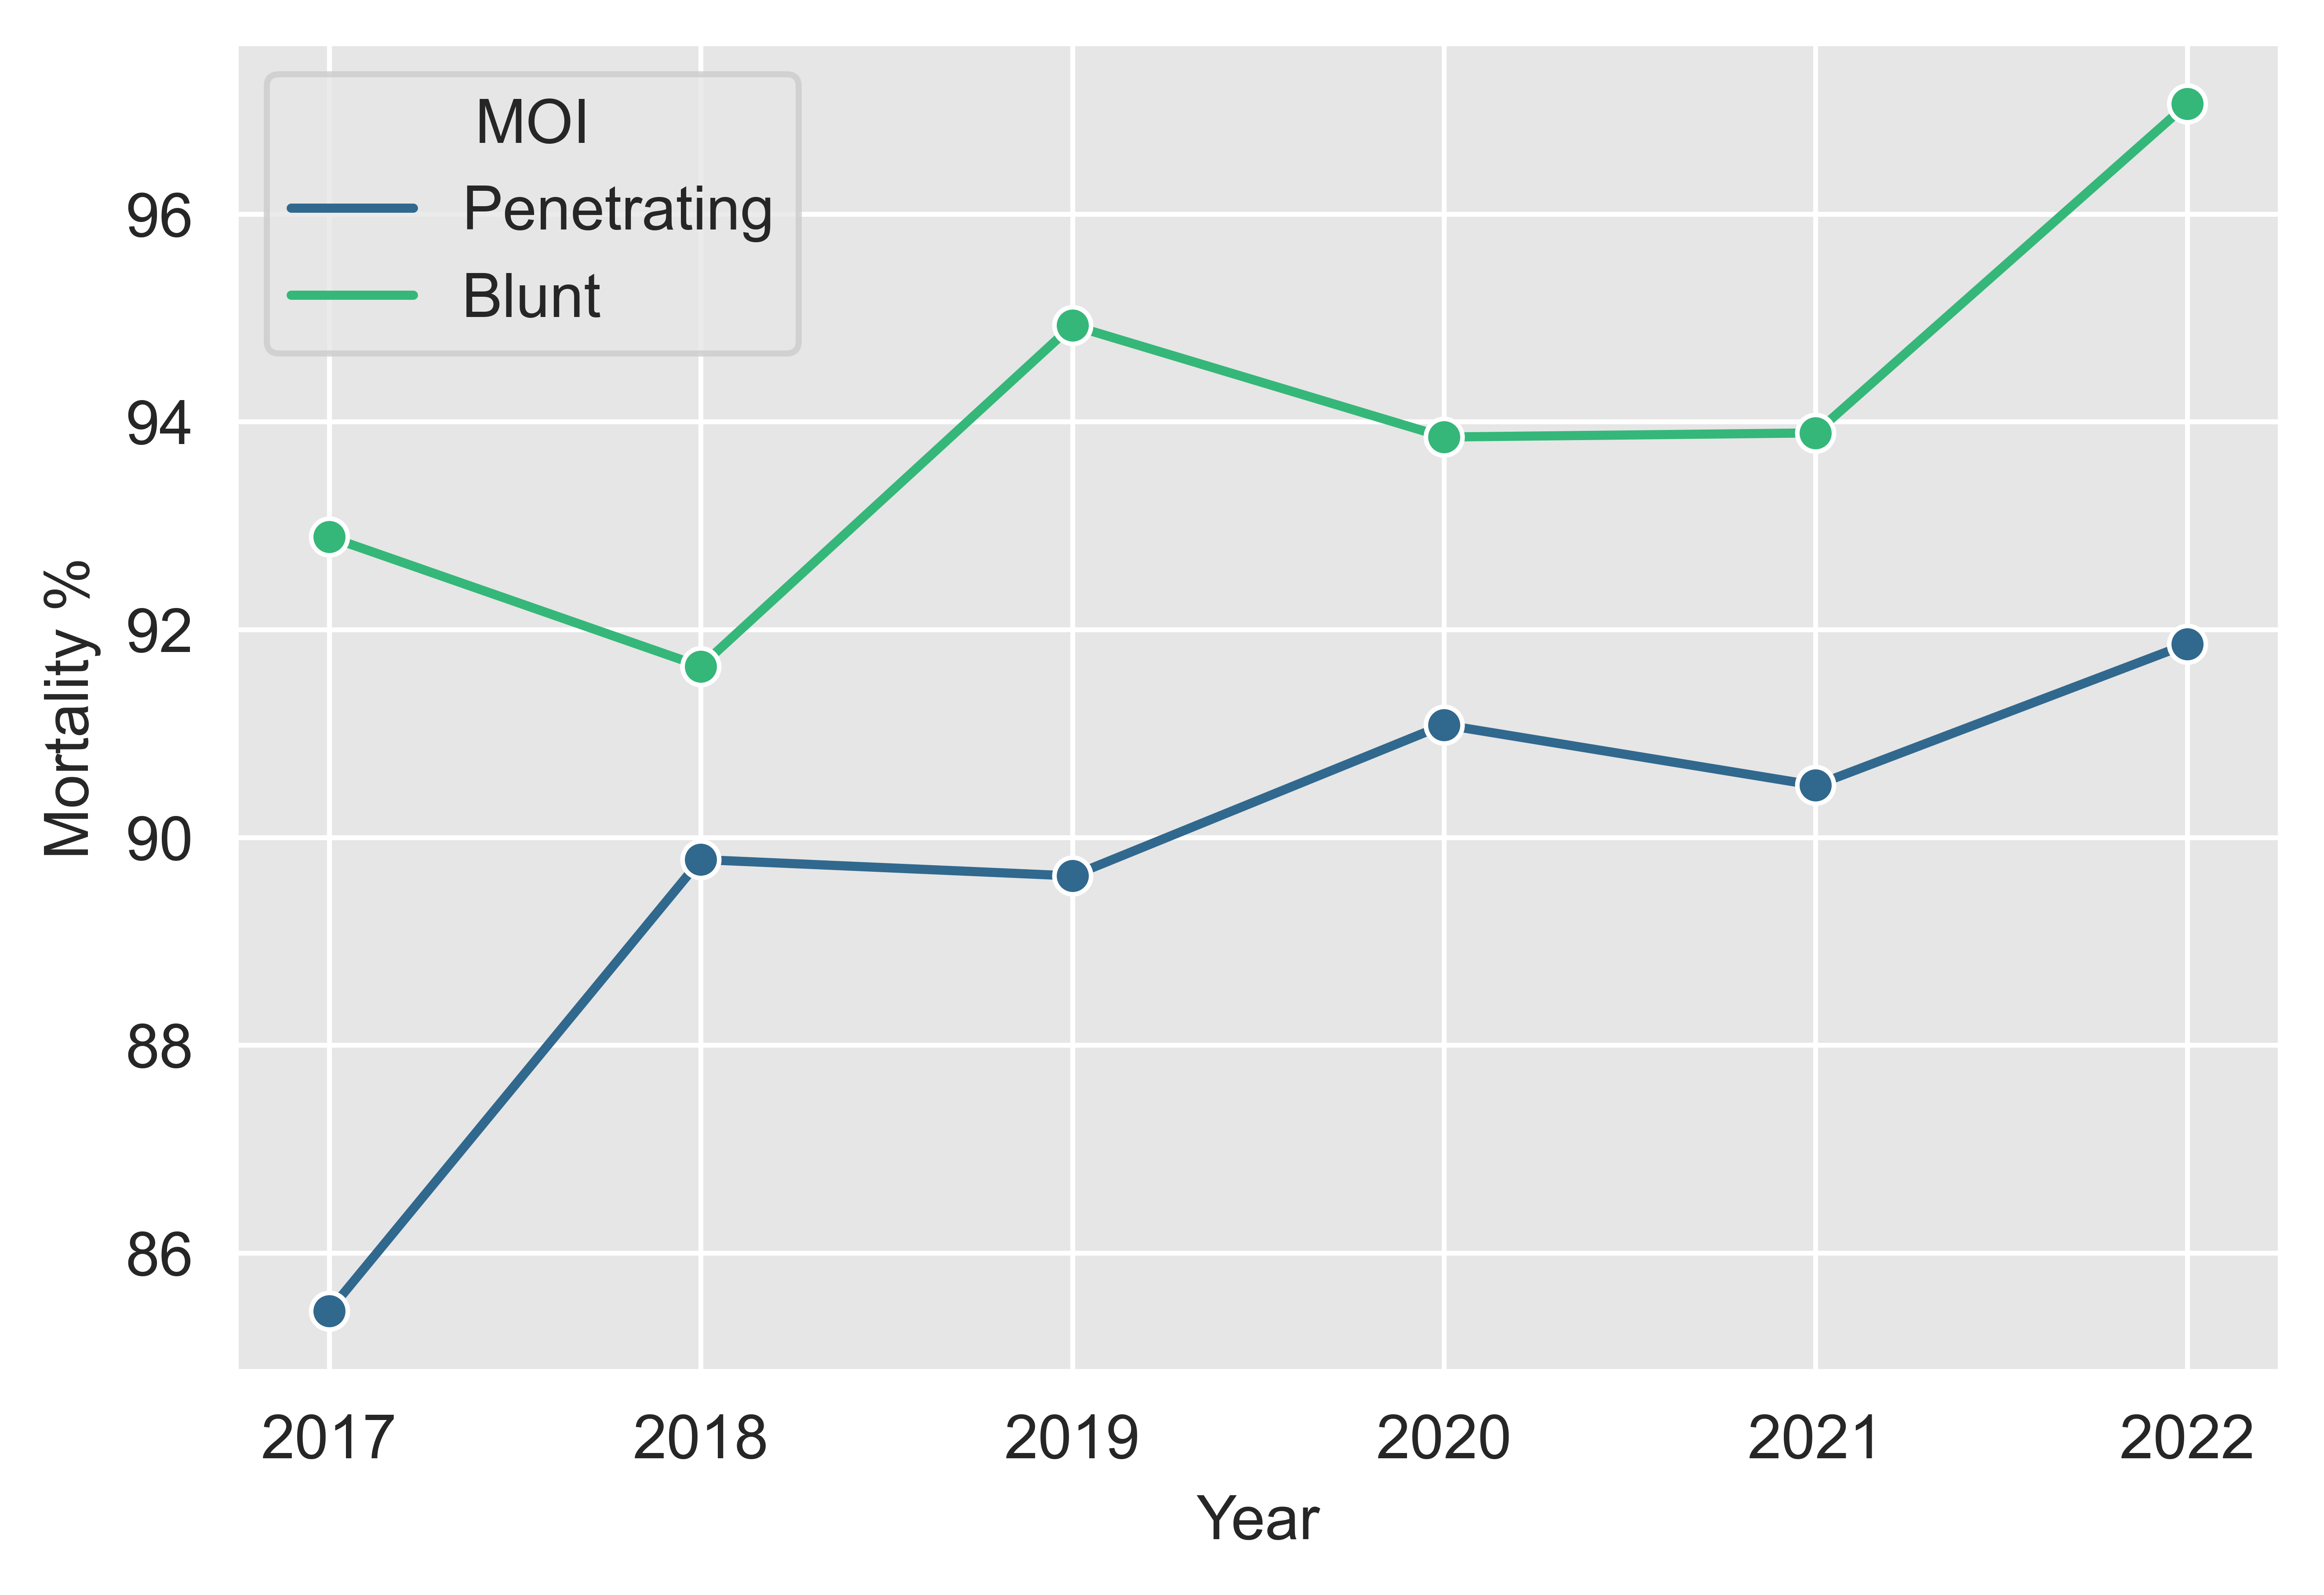

In [76]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)

g = sns.lineplot(data=mortality_year_table,
               y='Mortality %',
               x='Year',
               hue='MOI',
               palette='viridis',
               marker='o')
tick_labels = np.arange(mortality_year_table['Year'].min(), mortality_year_table['Year'].max() + 1)
g.set_xticks(tick_labels)
g.set_xticklabels(tick_labels.astype(int))
plt.show()

# Within 20 minutes of arrival

In [77]:
mortality_year_table = pd.DataFrame(columns=['Year', 'Mortality %', 'MOI', 'Thoracotomies Performed (Year Total for All MOI)'])
years = range(2017, 2023) # set to year 2016 for max with this part of pipeline
for year in years:
    year_df = TRAUMA_all_df[TRAUMA_all_df['Year'] == year]
    year_df = year_df[year_df['HMRRHGCTRLSURGMINS'] <= 20.0]
    penetrating_df = year_df[year_df['TRAUMATYPE'].isin(['Penetrating'])]
    expired_pen_df1 = penetrating_df[penetrating_df['EDDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
    expired_pen_df2 = penetrating_df[penetrating_df['HOSPDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
    mortality_pen_p = ((np.shape(expired_pen_df1)[0] + np.shape(expired_pen_df2)[0])/np.shape(penetrating_df)[0]) * 100
    blunt_df = year_df[year_df['TRAUMATYPE'].isin(['Blunt'])]
    expired_blunt_df1 = blunt_df[blunt_df['EDDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
    expired_blunt_df2 = blunt_df[blunt_df['HOSPDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
    mortality_blunt_p = ((np.shape(expired_blunt_df1)[0] + np.shape(expired_blunt_df2)[0])/np.shape(blunt_df)[0]) * 100
    final_pen_df = pd.DataFrame([[year, mortality_pen_p, 'Penetrating', np.shape(penetrating_df)[0]]], columns=['Year', 'Mortality %', 'MOI', 'Thoracotomies Performed (Year Total for All MOI)'])
    final_blunt_df = pd.DataFrame([[year, mortality_blunt_p, 'Blunt', np.shape(blunt_df)[0]]], columns=['Year', 'Mortality %', 'MOI', 'Thoracotomies Performed (Year Total for All MOI)'])
    combined_df = pd.DataFrame(np.vstack((final_pen_df, final_blunt_df)), columns=['Year', 'Mortality %', 'MOI', 'Thoracotomies Performed (Year Total for All MOI)'])
    mortality_year_table = pd.concat([mortality_year_table, combined_df])
mortality_year_table['Mortality %'] = mortality_year_table['Mortality %'].astype(float)
mortality_year_table['Year'] = mortality_year_table['Year'].astype(int)
display(mortality_year_table)

Year  Mortality %          MOI  \
0  2017    85.447761  Penetrating   
1  2017    94.082840        Blunt   
0  2018    90.123457  Penetrating   
1  2018    92.397661        Blunt   
0  2019    89.629630  Penetrating   
1  2019    94.927536        Blunt   
0  2020    91.083916  Penetrating   
1  2020    93.853428        Blunt   
0  2021    90.500864  Penetrating   
1  2021    93.893130        Blunt   
0  2022    91.860465  Penetrating   
1  2022    97.058824        Blunt   

  Thoracotomies Performed (Year Total for All MOI)  
0                                              804  
1                                              338  
0                                              810  
1                                              342  
0                                              810  
1                                              414  
0                                             1144  
1                                              423  
0                                             1158  
1                                              524  
0                                             1118  
1                                              544

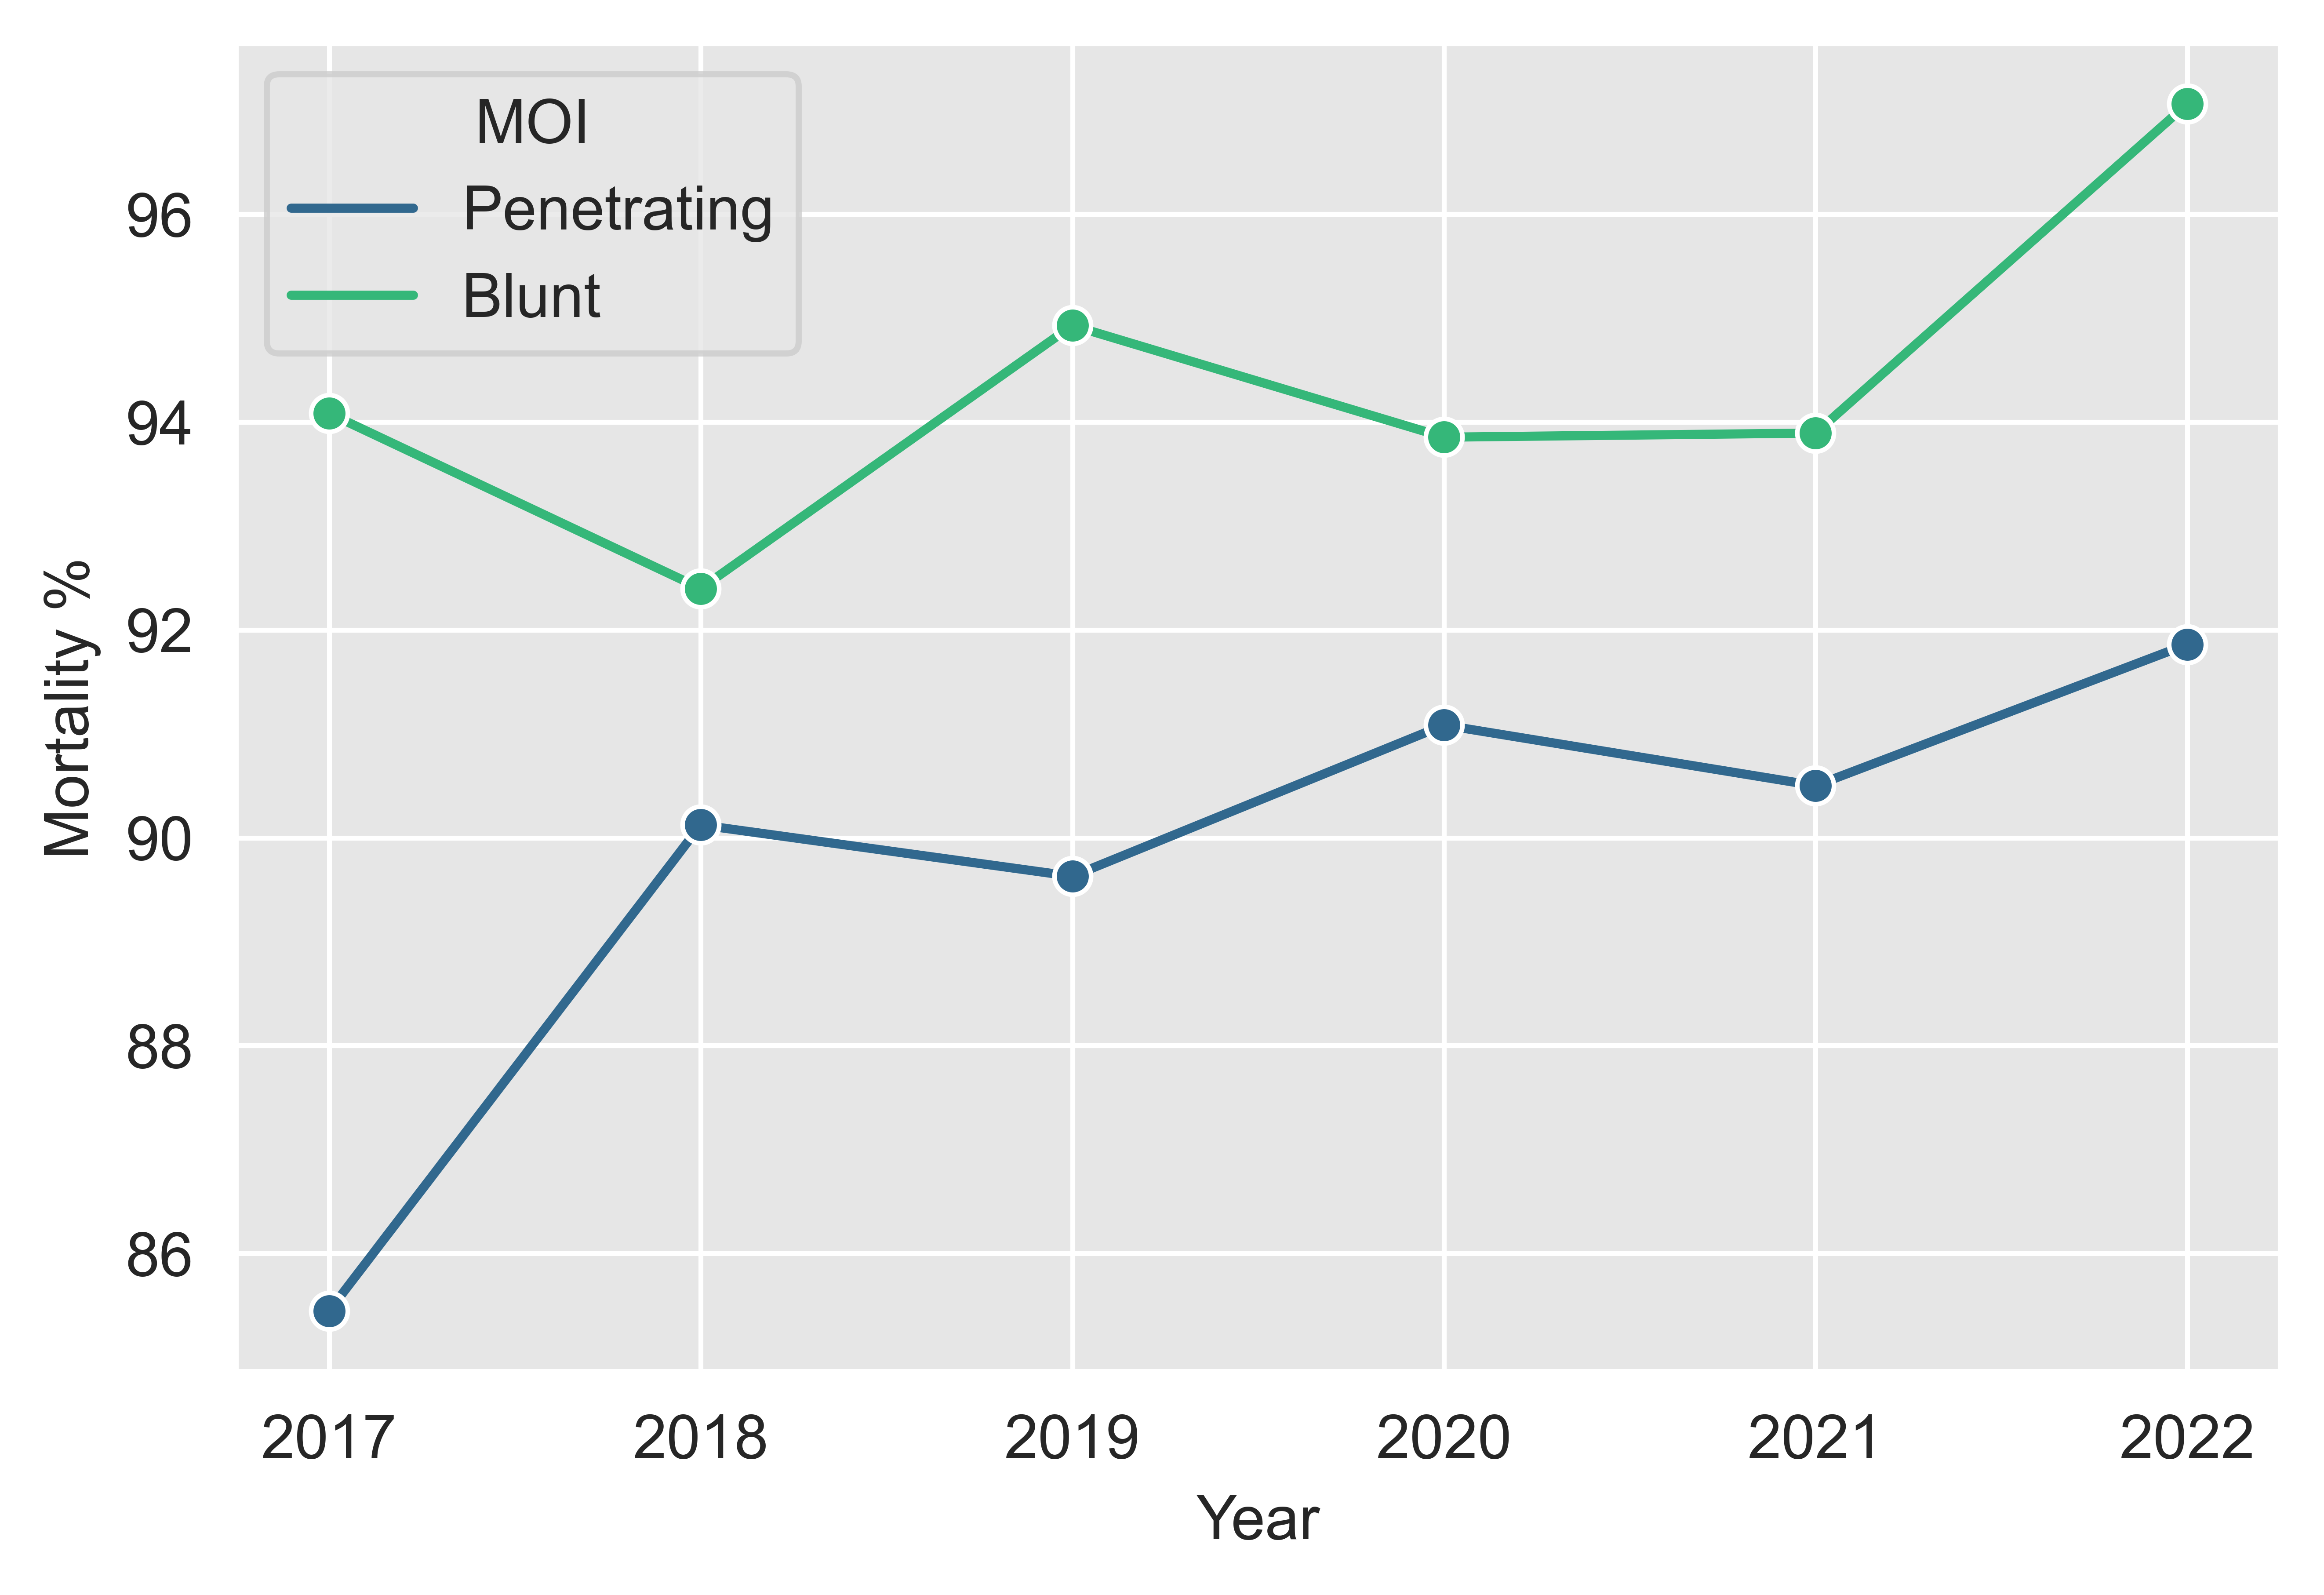

In [78]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)

g = sns.lineplot(data=mortality_year_table,
               y='Mortality %',
               x='Year',
               hue='MOI',
               palette='viridis',
               marker='o')
tick_labels = np.arange(mortality_year_table['Year'].min(), mortality_year_table['Year'].max() + 1)
g.set_xticks(tick_labels)
g.set_xticklabels(tick_labels.astype(int))
plt.show()

# Within 10 minutes of arrival

In [79]:
mortality_year_table = pd.DataFrame(columns=['Year', 'Mortality %', 'MOI', 'Thoracotomies Performed (Year Total for All MOI)'])
years = range(2017, 2023) # set to year 2016 for max with this part of pipeline
for year in years:
    year_df = TRAUMA_all_df[TRAUMA_all_df['Year'] == year]
    year_df = year_df[year_df['HMRRHGCTRLSURGMINS'] <= 10.0]
    penetrating_df = year_df[year_df['TRAUMATYPE'].isin(['Penetrating'])]
    expired_pen_df1 = penetrating_df[penetrating_df['EDDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
    expired_pen_df2 = penetrating_df[penetrating_df['HOSPDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
    mortality_pen_p = ((np.shape(expired_pen_df1)[0] + np.shape(expired_pen_df2)[0])/np.shape(penetrating_df)[0]) * 100
    blunt_df = year_df[year_df['TRAUMATYPE'].isin(['Blunt'])]
    expired_blunt_df1 = blunt_df[blunt_df['EDDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
    expired_blunt_df2 = blunt_df[blunt_df['HOSPDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
    mortality_blunt_p = ((np.shape(expired_blunt_df1)[0] + np.shape(expired_blunt_df2)[0])/np.shape(blunt_df)[0]) * 100
    final_pen_df = pd.DataFrame([[year, mortality_pen_p, 'Penetrating', np.shape(penetrating_df)[0]]], columns=['Year', 'Mortality %', 'MOI', 'Thoracotomies Performed (Year Total for All MOI)'])
    final_blunt_df = pd.DataFrame([[year, mortality_blunt_p, 'Blunt', np.shape(blunt_df)[0]]], columns=['Year', 'Mortality %', 'MOI', 'Thoracotomies Performed (Year Total for All MOI)'])
    combined_df = pd.DataFrame(np.vstack((final_pen_df, final_blunt_df)), columns=['Year', 'Mortality %', 'MOI', 'Thoracotomies Performed (Year Total for All MOI)'])
    mortality_year_table = pd.concat([mortality_year_table, combined_df])
mortality_year_table['Mortality %'] = mortality_year_table['Mortality %'].astype(float)
mortality_year_table['Year'] = mortality_year_table['Year'].astype(int)
display(mortality_year_table)

Year  Mortality %          MOI  \
0  2017    92.631579  Penetrating   
1  2017    95.283019        Blunt   
0  2018    93.631670  Penetrating   
1  2018    93.965517        Blunt   
0  2019    93.939394  Penetrating   
1  2019    96.989967        Blunt   
0  2020    94.972067  Penetrating   
1  2020    96.357616        Blunt   
0  2021    94.692144  Penetrating   
1  2021    95.894428        Blunt   
0  2022    95.680346  Penetrating   
1  2022    98.191214        Blunt   

  Thoracotomies Performed (Year Total for All MOI)  
0                                              570  
1                                              212  
0                                              581  
1                                              232  
0                                              627  
1                                              299  
0                                              895  
1                                              302  
0                                              942  
1                                              341  
0                                              926  
1                                              387

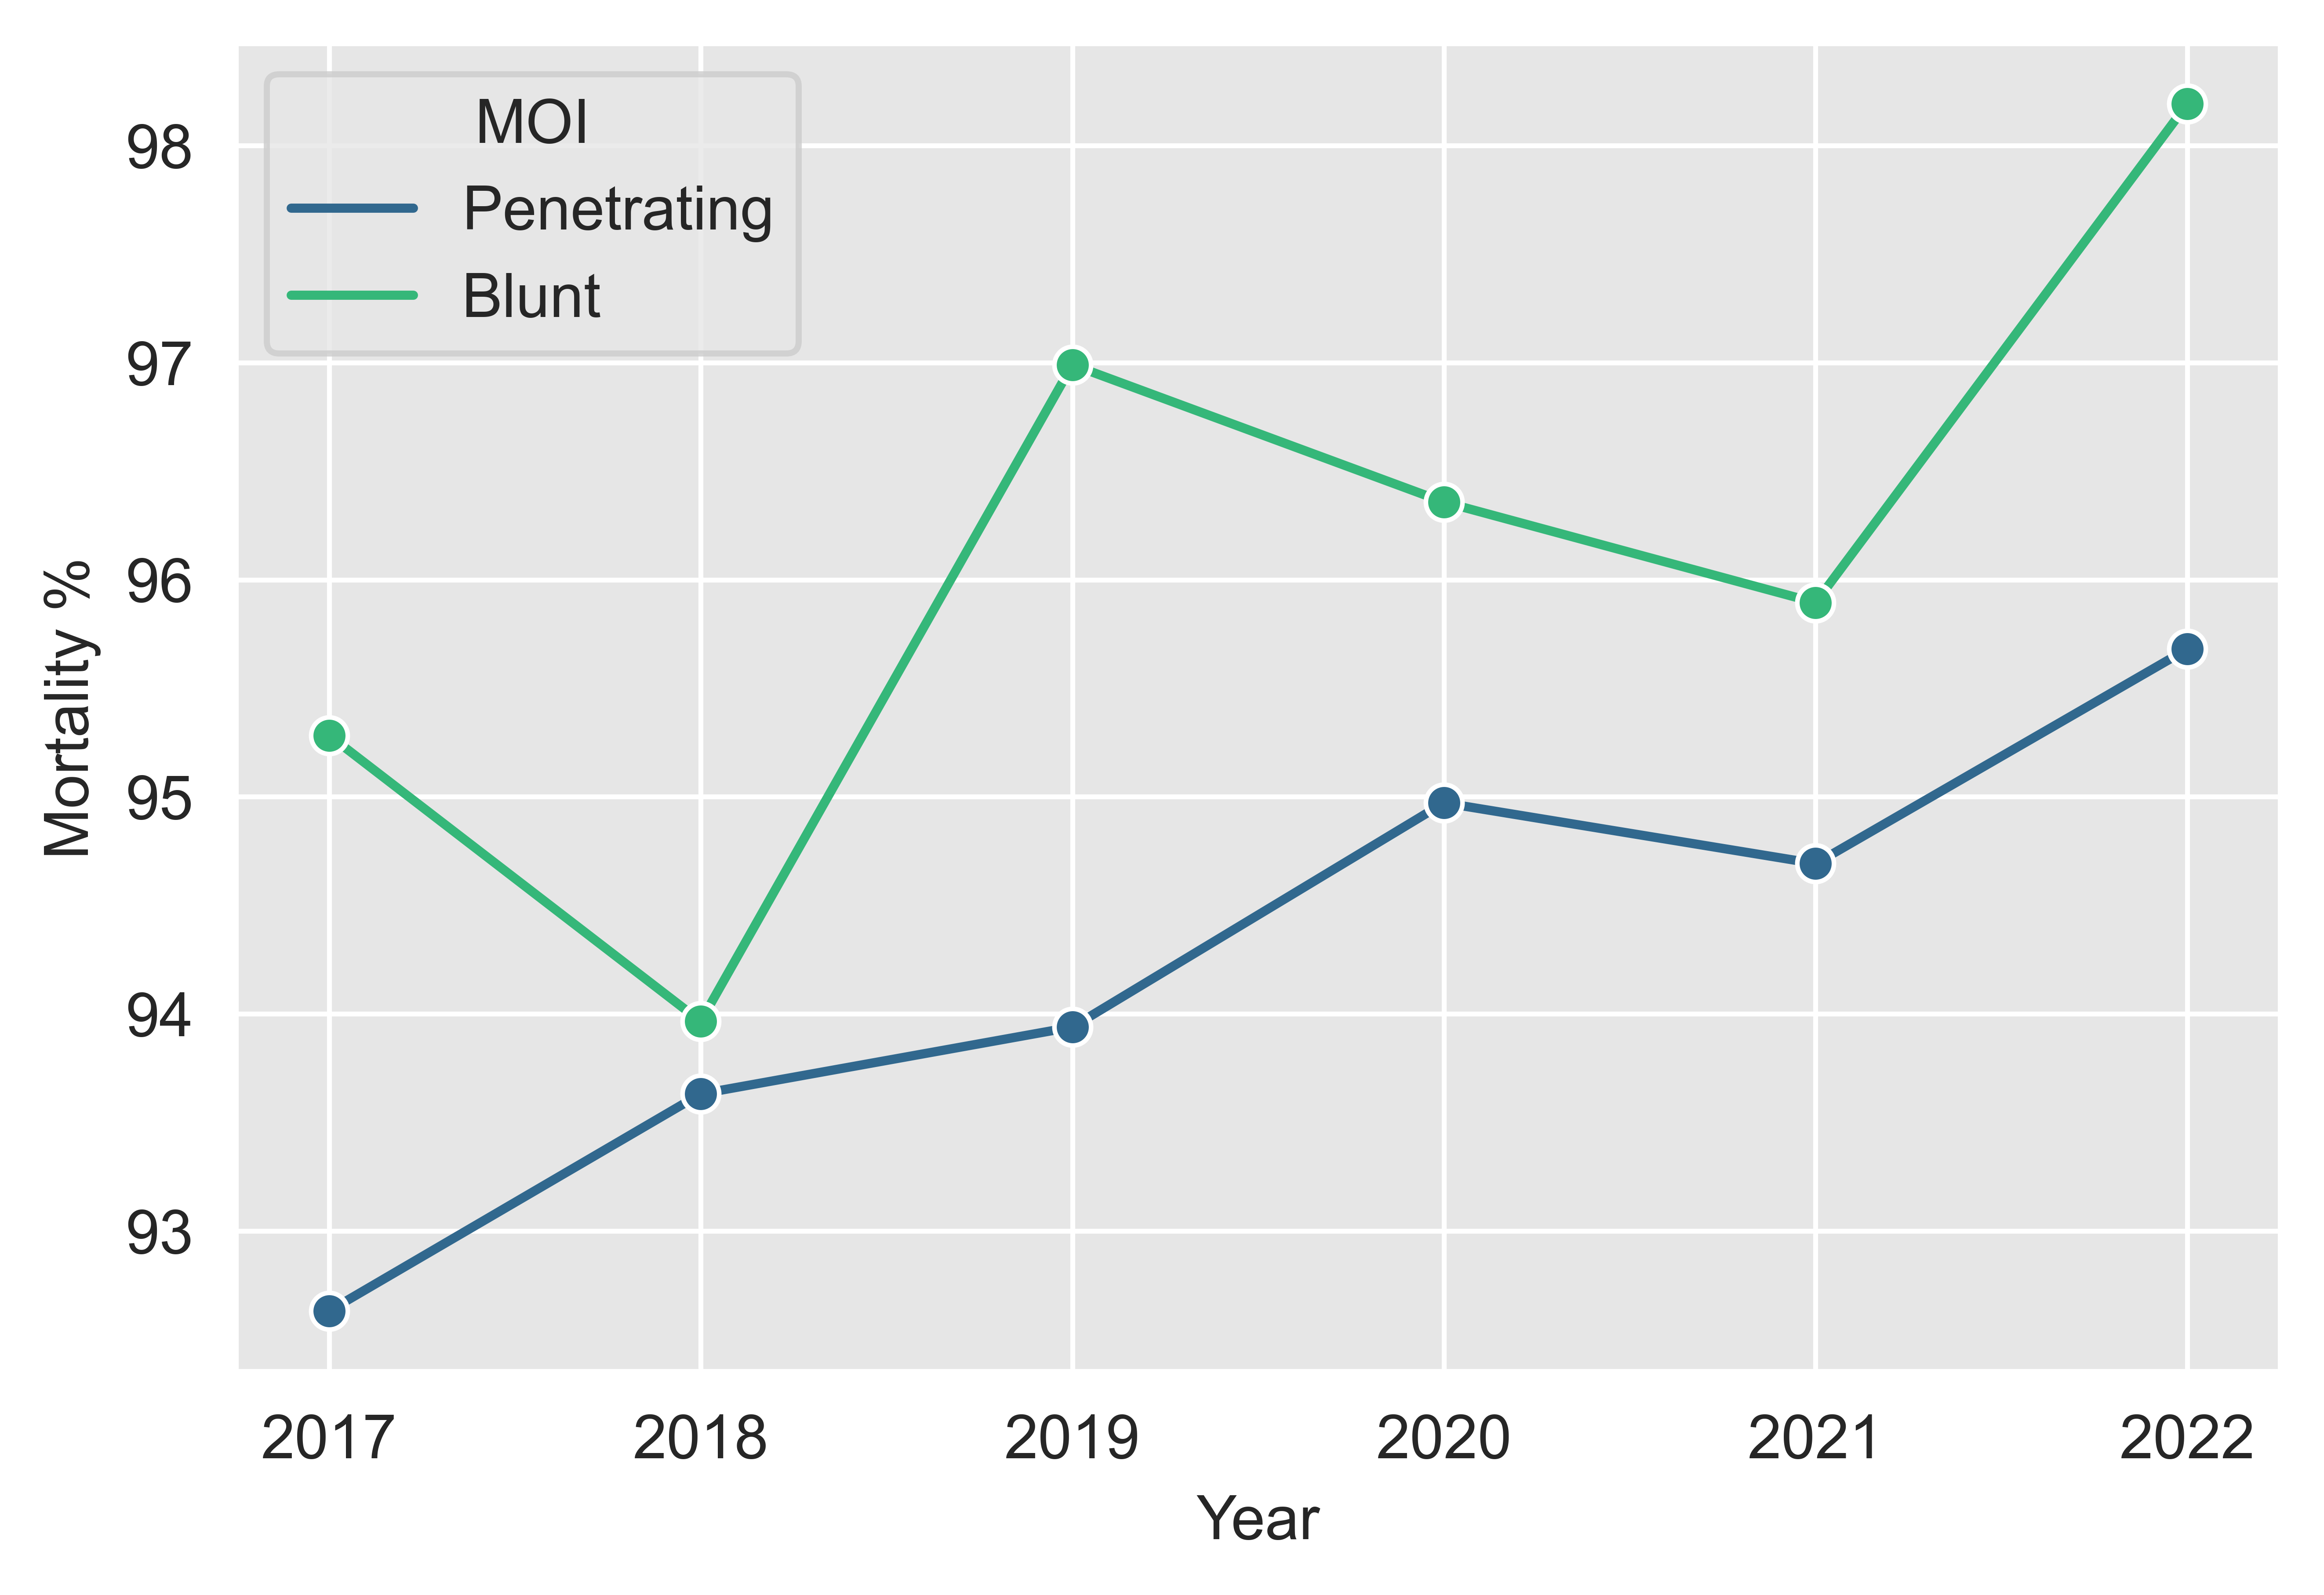

In [80]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)

g = sns.lineplot(data=mortality_year_table,
               y='Mortality %',
               x='Year',
               hue='MOI',
               palette='viridis',
               marker='o')
tick_labels = np.arange(mortality_year_table['Year'].min(), mortality_year_table['Year'].max() + 1)
g.set_xticks(tick_labels)
g.set_xticklabels(tick_labels.astype(int))
plt.show()

## Create `DataFrame` of Mortality by `Age` and `Trauma Type`

In [81]:
mortality_age_table = pd.DataFrame(columns=['Mortality %', 'Trauma Type', 'Age Range', '# of Cases'])
age_ranges = range(0, 90, 10)

for age_range in age_ranges:
    age_range_df = TRAUMA_all_df[(TRAUMA_all_df['AGEYEARS'] > age_range+1) & (TRAUMA_all_df['AGEYEARS'] <= age_range+10)]
    age_range_df = age_range_df[age_range_df['HMRRHGCTRLSURGMINS'] <= 20.0]
    penetrating_df = age_range_df[age_range_df['TRAUMATYPE'].isin(['Penetrating'])]
    expired_pen_df1 = penetrating_df[penetrating_df['EDDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
    expired_pen_df2 = penetrating_df[penetrating_df['HOSPDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
    mortality_pen_p = ((np.shape(expired_pen_df1)[0] + np.shape(expired_pen_df2)[0])/np.shape(penetrating_df)[0]) * 100
    blunt_df = age_range_df[age_range_df['TRAUMATYPE'].isin(['Blunt'])]
    expired_blunt_df1 = blunt_df[blunt_df['EDDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
    expired_blunt_df2 = blunt_df[blunt_df['HOSPDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
    mortality_blunt_p = ((np.shape(expired_blunt_df1)[0] + np.shape(expired_blunt_df2)[0])/np.shape(blunt_df)[0]) * 100
    final_pen_df = pd.DataFrame([[mortality_pen_p, 'Penetrating']], columns=['Mortality %', 'Trauma Type'])
    final_blunt_df = pd.DataFrame([[mortality_blunt_p, 'Blunt']], columns=['Mortality %', 'Trauma Type'])
    final_pen_df['Age Range'] = '%i - %i'%(age_range+1, age_range+10)
    final_blunt_df['Age Range'] = '%i - %i'%(age_range+1, age_range+10)
    final_pen_df['# of Cases'] = np.shape(penetrating_df)[0]
    final_blunt_df['# of Cases'] = np.shape(blunt_df)[0]
    combined_df = pd.DataFrame(np.vstack((final_pen_df, final_blunt_df)), columns=['Mortality %', 'Trauma Type', 'Age Range', '# of Cases'])
    mortality_age_table = pd.concat([mortality_age_table, combined_df])
mortality_age_table['Mortality %'] = mortality_age_table['Mortality %'].astype(float)
mortality_age_table['Age Range'] = mortality_age_table['Age Range'].astype(str)
display(mortality_age_table)

Mortality %  Trauma Type Age Range # of Cases
0    94.444444  Penetrating    1 - 10         36
1    88.888889        Blunt    1 - 10         27
0    88.241107  Penetrating   11 - 20       1012
1    93.965517        Blunt   11 - 20        232
0    90.529532  Penetrating   21 - 30       1964
1    93.714286        Blunt   21 - 30        525
0    90.049342  Penetrating   31 - 40       1216
1    94.199536        Blunt   31 - 40        431
0    90.222985  Penetrating   41 - 50        583
1    95.076923        Blunt   41 - 50        325
0    90.251572  Penetrating   51 - 60        318
1    94.610778        Blunt   51 - 60        334
0    91.428571  Penetrating   61 - 70        105
1    96.282528        Blunt   61 - 70        269
0   100.000000  Penetrating   71 - 80         26
1    94.927536        Blunt   71 - 80        138
0   100.000000  Penetrating   81 - 90          4
1    92.982456        Blunt   81 - 90         57

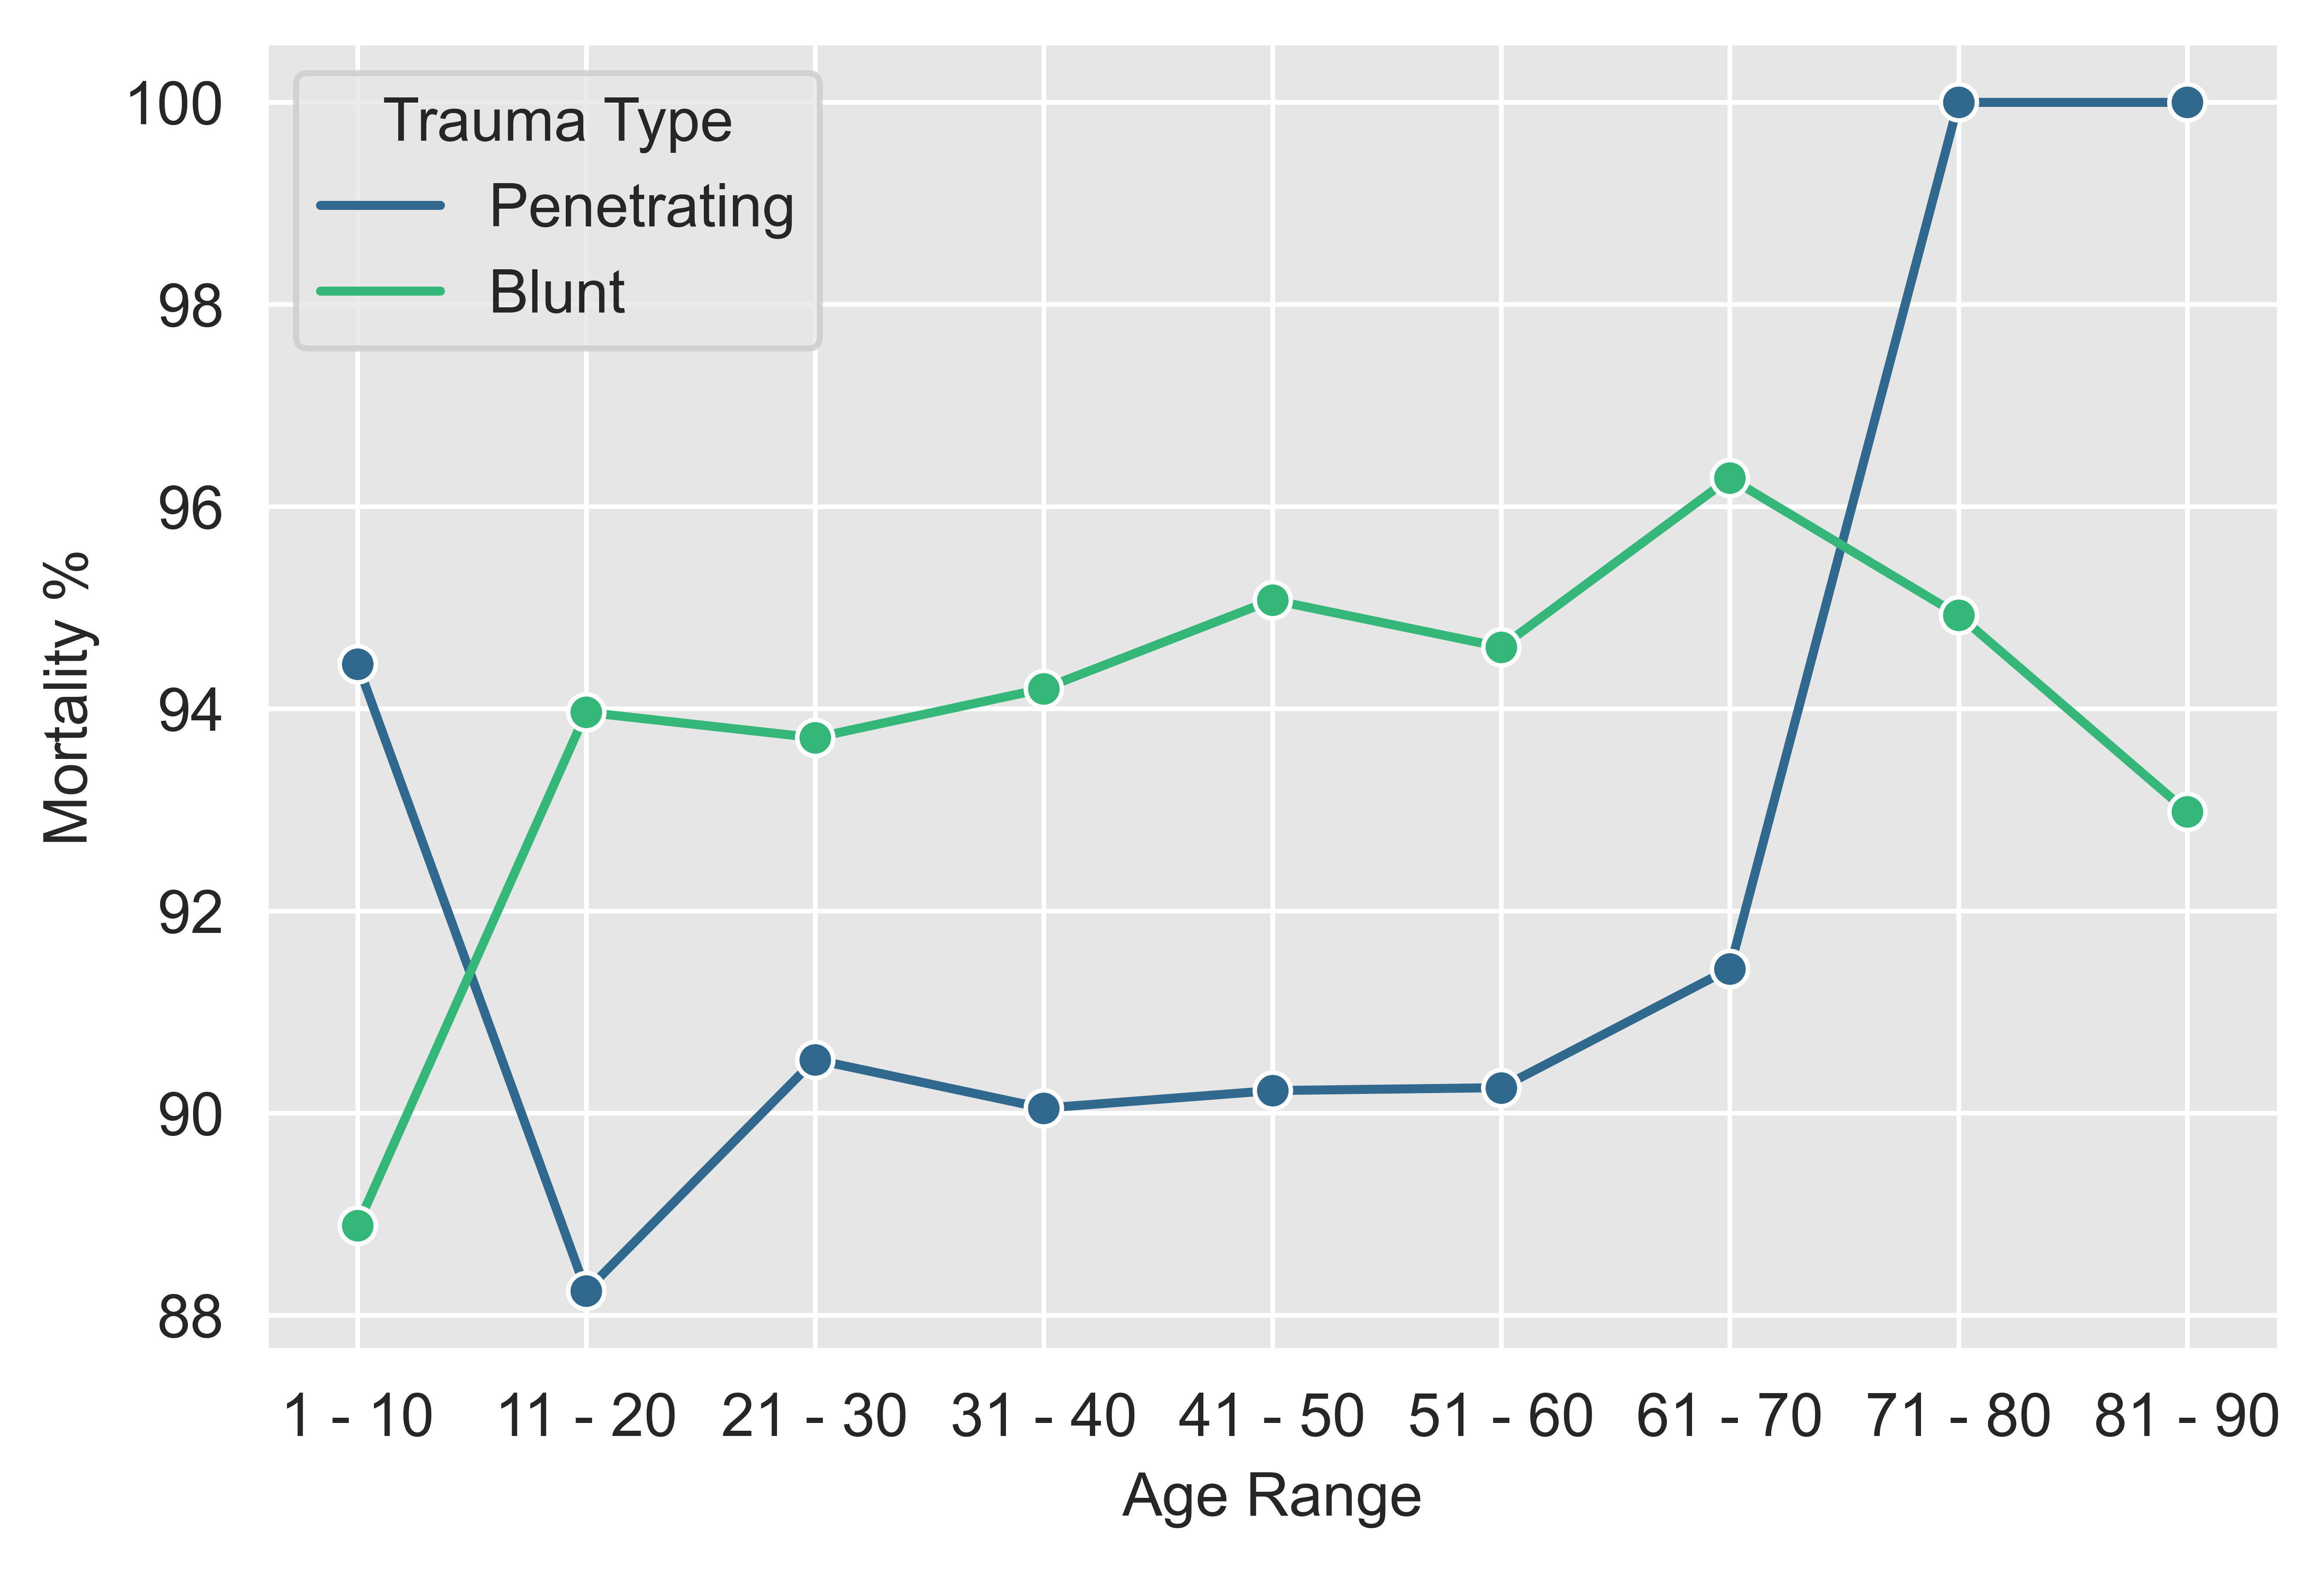

In [82]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)

g = sns.lineplot(data=mortality_age_table,
               y='Mortality %',
               x='Age Range',
               hue='Trauma Type',
               palette='viridis',
               marker='o')
plt.show()

## Create `DataFrame` of Mortality by `PROCEDUREMINS` and `Trauma Type`

In [83]:
proc_times = range(0, 61, 1)
mortality_proctime_table = pd.DataFrame(columns=['Mortality %', 'Trauma Type', 'Procedure Time (Minutes after ED Arrival)', '# of Cases'])
for time in proc_times:
    trauma_time_df = TRAUMA_all_df.loc[TRAUMA_all_df['HMRRHGCTRLSURGMINS'] == time]
    penetrating_df = trauma_time_df[trauma_time_df['TRAUMATYPE'].isin(['Penetrating'])]
    expired_pen_df1 = penetrating_df[penetrating_df['EDDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
    expired_pen_df2 = penetrating_df[penetrating_df['HOSPDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
    mortality_pen_p = ((np.shape(expired_pen_df1)[0] + np.shape(expired_pen_df2)[0])/np.shape(penetrating_df)[0]) * 100
    blunt_df = trauma_time_df[trauma_time_df['TRAUMATYPE'].isin(['Blunt'])]
    expired_blunt_df1 = blunt_df[blunt_df['EDDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
    expired_blunt_df2 = blunt_df[blunt_df['HOSPDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
    mortality_blunt_p = ((np.shape(expired_blunt_df1)[0] + np.shape(expired_blunt_df2)[0])/np.shape(blunt_df)[0]) * 100
    final_pen_df = pd.DataFrame([[mortality_pen_p, 'Penetrating']], columns=['Mortality %', 'Trauma Type'])
    final_blunt_df = pd.DataFrame([[mortality_blunt_p, 'Blunt']], columns=['Mortality %', 'Trauma Type'])
    final_pen_df['Procedure Time (Minutes after ED Arrival)'] = time
    final_blunt_df['Procedure Time (Minutes after ED Arrival)'] = time
    final_pen_df['# of Cases'] = np.shape(penetrating_df)[0]
    final_blunt_df['# of Cases'] = np.shape(blunt_df)[0]
    combined_df = pd.DataFrame(np.vstack((final_pen_df, final_blunt_df)), columns=['Mortality %', 'Trauma Type', 'Procedure Time (Minutes after ED Arrival)', '# of Cases'])
    mortality_proctime_table = pd.concat([mortality_proctime_table, combined_df])
mortality_proctime_table['Mortality %'] = mortality_proctime_table['Mortality %'].astype(float)
display(mortality_proctime_table.head())

ZeroDivisionError: division by zero

In [ ]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)

g = sns.lineplot(data=mortality_proctime_table,
               y='Mortality %',
               x='Procedure Time (Minutes after ED Arrival)',
               hue='Trauma Type',
               palette='viridis',
               marker='o')
plt.show()

In [ ]:
proc_times = range(0, 21, 1)
mortality_proctime_table = pd.DataFrame(columns=['Mortality %', 'Trauma Type', 'Procedure Time (Minutes after ED Arrival)', '# of Cases'])
for time in proc_times:
    trauma_time_df = TRAUMA_all_df.loc[TRAUMA_all_df['HMRRHGCTRLSURGMINS'] == time]
    penetrating_df = trauma_time_df[trauma_time_df['TRAUMATYPE'].isin(['Penetrating'])]
    expired_pen_df1 = penetrating_df[penetrating_df['EDDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
    expired_pen_df2 = penetrating_df[penetrating_df['HOSPDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
    mortality_pen_p = ((np.shape(expired_pen_df1)[0] + np.shape(expired_pen_df2)[0])/np.shape(penetrating_df)[0]) * 100
    blunt_df = trauma_time_df[trauma_time_df['TRAUMATYPE'].isin(['Blunt'])]
    expired_blunt_df1 = blunt_df[blunt_df['EDDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
    expired_blunt_df2 = blunt_df[blunt_df['HOSPDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
    mortality_blunt_p = ((np.shape(expired_blunt_df1)[0] + np.shape(expired_blunt_df2)[0])/np.shape(blunt_df)[0]) * 100
    final_pen_df = pd.DataFrame([[mortality_pen_p, 'Penetrating']], columns=['Mortality %', 'Trauma Type'])
    final_blunt_df = pd.DataFrame([[mortality_blunt_p, 'Blunt']], columns=['Mortality %', 'Trauma Type'])
    final_pen_df['Procedure Time (Minutes after ED Arrival)'] = time
    final_blunt_df['Procedure Time (Minutes after ED Arrival)'] = time
    final_pen_df['# of Cases'] = np.shape(penetrating_df)[0]
    final_blunt_df['# of Cases'] = np.shape(blunt_df)[0]
    combined_df = pd.DataFrame(np.vstack((final_pen_df, final_blunt_df)), columns=['Mortality %', 'Trauma Type', 'Procedure Time (Minutes after ED Arrival)', '# of Cases'])
    mortality_proctime_table = pd.concat([mortality_proctime_table, combined_df])
mortality_proctime_table['Mortality %'] = mortality_proctime_table['Mortality %'].astype(float)
display(mortality_proctime_table.head())

In [ ]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)

g = sns.lineplot(data=mortality_proctime_table,
               y='Mortality %',
               x='Procedure Time (Minutes after ED Arrival)',
               hue='Trauma Type',
               palette='viridis',
               marker='o')
plt.show()

In [ ]:
proc_times = range(0, 11, 1)
mortality_proctime_table = pd.DataFrame(columns=['Mortality %', 'Trauma Type', 'Procedure Time (Minutes after ED Arrival)', '# of Cases'])
for time in proc_times:
    trauma_time_df = TRAUMA_all_df.loc[TRAUMA_all_df['HMRRHGCTRLSURGMINS'] == time]
    penetrating_df = trauma_time_df[trauma_time_df['TRAUMATYPE'].isin(['Penetrating'])]
    expired_pen_df1 = penetrating_df[penetrating_df['EDDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
    expired_pen_df2 = penetrating_df[penetrating_df['HOSPDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
    mortality_pen_p = ((np.shape(expired_pen_df1)[0] + np.shape(expired_pen_df2)[0])/np.shape(penetrating_df)[0]) * 100
    blunt_df = trauma_time_df[trauma_time_df['TRAUMATYPE'].isin(['Blunt'])]
    expired_blunt_df1 = blunt_df[blunt_df['EDDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
    expired_blunt_df2 = blunt_df[blunt_df['HOSPDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
    mortality_blunt_p = ((np.shape(expired_blunt_df1)[0] + np.shape(expired_blunt_df2)[0])/np.shape(blunt_df)[0]) * 100
    final_pen_df = pd.DataFrame([[mortality_pen_p, 'Penetrating']], columns=['Mortality %', 'Trauma Type'])
    final_blunt_df = pd.DataFrame([[mortality_blunt_p, 'Blunt']], columns=['Mortality %', 'Trauma Type'])
    final_pen_df['Procedure Time (Minutes after ED Arrival)'] = time
    final_blunt_df['Procedure Time (Minutes after ED Arrival)'] = time
    final_pen_df['# of Cases'] = np.shape(penetrating_df)[0]
    final_blunt_df['# of Cases'] = np.shape(blunt_df)[0]
    combined_df = pd.DataFrame(np.vstack((final_pen_df, final_blunt_df)), columns=['Mortality %', 'Trauma Type', 'Procedure Time (Minutes after ED Arrival)', '# of Cases'])
    mortality_proctime_table = pd.concat([mortality_proctime_table, combined_df])
mortality_proctime_table['Mortality %'] = mortality_proctime_table['Mortality %'].astype(float)
display(mortality_proctime_table.head())

In [ ]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)

g = sns.lineplot(data=mortality_proctime_table,
               y='Mortality %',
               x='Procedure Time (Minutes after ED Arrival)',
               hue='Trauma Type',
               palette='viridis',
               marker='o')
plt.show()

In [ ]:
proc_times = range(0, 21, 1)
mortality_proctime_table = pd.DataFrame(columns=['Mortality %', 'Trauma Type', 'Procedure Time (Minutes after ED Arrival)', '# of Cases'])
for time in proc_times:
    trauma_time_df = TRAUMA_all_df.loc[TRAUMA_all_df['HMRRHGCTRLSURGMINS'] == time]
    penetrating_df = trauma_time_df[trauma_time_df['TRAUMATYPE'].isin(['Penetrating'])]
    expired_pen_df1 = penetrating_df[penetrating_df['EDDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
    expired_pen_df2 = penetrating_df[penetrating_df['HOSPDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
    mortality_pen_p = ((np.shape(expired_pen_df1)[0] + np.shape(expired_pen_df2)[0])/np.shape(penetrating_df)[0]) * 100
    blunt_df = trauma_time_df[trauma_time_df['TRAUMATYPE'].isin(['Blunt'])]
    expired_blunt_df1 = blunt_df[blunt_df['EDDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
    expired_blunt_df2 = blunt_df[blunt_df['HOSPDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
    mortality_blunt_p = ((np.shape(expired_blunt_df1)[0] + np.shape(expired_blunt_df2)[0])/np.shape(blunt_df)[0]) * 100
    final_pen_df = pd.DataFrame([[mortality_pen_p, 'Penetrating']], columns=['Mortality %', 'Trauma Type'])
    final_blunt_df = pd.DataFrame([[mortality_blunt_p, 'Blunt']], columns=['Mortality %', 'Trauma Type'])
    final_pen_df['Procedure Time (Minutes after ED Arrival)'] = time
    final_blunt_df['Procedure Time (Minutes after ED Arrival)'] = time
    final_pen_df['# of Cases'] = np.shape(penetrating_df)[0]
    final_blunt_df['# of Cases'] = np.shape(blunt_df)[0]
    combined_df = pd.DataFrame(np.vstack((final_pen_df, final_blunt_df)), columns=['Mortality %', 'Trauma Type', 'Procedure Time (Minutes after ED Arrival)', '# of Cases'])
    mortality_proctime_table = pd.concat([mortality_proctime_table, combined_df])
mortality_proctime_table['Mortality %'] = mortality_proctime_table['Mortality %'].astype(float)
display(mortality_proctime_table.head())

In [ ]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)

g = sns.barplot(data=mortality_proctime_table, x='Procedure Time (Minutes after ED Arrival)', y='# of Cases', hue='Trauma Type', palette='viridis')
plt.show()

In [ ]:
mortality_mechanism_table = pd.DataFrame(columns=['Mortality %', 'Mechanism', 'Age Range', '# of Cases'])
age_ranges = range(0, 90, 10)
trauma_types = TRAUMA_all_df['MECHANISM'].unique()

for age_range in age_ranges:
    for trauma_type in trauma_types:
        age_range_df = TRAUMA_all_df[(TRAUMA_all_df['AGEYEARS'] > age_range + 1) & (TRAUMA_all_df['AGEYEARS'] <= age_range + 10)]
        trauma_type_df = age_range_df[age_range_df['MECHANISM'] == trauma_type]
        
        expired_df1 = trauma_type_df[trauma_type_df['EDDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
        expired_df2 = trauma_type_df[trauma_type_df['HOSPDISCHARGEDISPOSITION'].isin(['Expired', 'Deceased/Expired', 'Deceased/expired'])]
        
        if np.shape(trauma_type_df)[0] == 0:
            mortality_p = np.nan
        else:
            mortality_p = ((np.shape(expired_df1)[0] + np.shape(expired_df2)[0]) / np.shape(trauma_type_df)[0]) * 100
        
        final_df = pd.DataFrame([[mortality_p, trauma_type]], columns=['Mortality %', 'Mechanism'])
        final_df['Age Range'] = '%i - %i' % (age_range + 1, age_range + 10)
        final_df['# of Cases'] = np.shape(trauma_type_df)[0]
        
        combined_df = pd.DataFrame(final_df, columns=['Mortality %', 'Mechanism', 'Age Range', '# of Cases'])
        mortality_mechanism_table = pd.concat([mortality_mechanism_table, combined_df])

mortality_mechanism_table['Mortality %'] = mortality_mechanism_table['Mortality %'].astype(float)
mortality_mechanism_table['Age Range'] = mortality_mechanism_table['Age Range'].astype(str)
mortality_mechanism_table.reset_index(drop=True, inplace=True)

display(mortality_mechanism_table.head())

In [ ]:
mpl.rcParams['figure.dpi'] = 1000
sns.set_style('darkgrid', {"axes.facecolor": ".9"})
sns.color_palette("viridis", as_cmap=True)

g = sns.pointplot(data=mortality_mechanism_table,
               x='Mortality %',
               y='Mechanism', 
               ci=None,
               orient='h',
               join=False)
g.tick_params(axis='y', rotation=0, labelsize='small')
plt.grid(True, which='both', linestyle='--')
g.set_xlim(85, 101)
plt.show()